## DOCUMENTATION  
this is just the initial documenatation whcih will be improved once we integrate in Github

In [1]:
# Date        Initials    Description
# 10FEB2023   PN          - Initial Library, USGS Load for 2023, 48 Philippines stations, 50/10 data extract, RasberryShape Data Extract loop


#Future add ASAP (as of 5 April 2024)
# MMF 3 year data extract loop, Initial Arima, K-Mean, and LSTM model mode, Log/Lat extraction for each station, and Closest 5 stations to eartquake loop
# PN STA and LTA features, Auto Trigger function

## Initial PIP installation


In [ ]:
# ! pip install obspy # enable line when using temporary notebook/instance
# ! mkdir /content/rs-usgs-test
# ! cd /content/rs-usgs-test && gdown https://drive.google.com/uc?id=1K4ivaWZBZi_26JmFwqOH1GP2q8jO15Rv

In [ ]:
# Instance information for any diagnostics use

! python --version
! nproc

## Library Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import obspy

from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime, Stream, Trace

import os
import threading
import time

from concurrent.futures import ThreadPoolExecutor as ccf_tpe
from concurrent.futures import ProcessPoolExecutor as ccf_ppe
from tqdm import tqdm
from geopy.distance import geodesic

In [2]:
os.cpu_count()

16

## Loading USGS Dataset with every earthquake

Please make sure to add the "assets" folder in the same folder as ML004 notebook

In [3]:
usgs_data = 'assets/DS001_USGS_dataset 1950-2023.csv'

usgs_df = pd.read_csv(usgs_data)                # loads csv to dataframe
usgs_df.time = pd.to_datetime(usgs_df.time)     # convert object type to datetime64

year_lim = 2023

usgs_df_lim = usgs_df[usgs_df.time.dt.year >= year_lim]
usgs_df_lim.reset_index(inplace=True)

In [ ]:
filtered = usgs_df_lim[(usgs_df_lim['mag'] >= 5) & (usgs_df_lim['depth'] <= 10)].reset_index()
filtered.columns

In [4]:
usgs_df_lim

,index,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,0,2023-07-08 10:13:00.166000+00:00,8.9833,127.2022,10.000,4.5,mb,34.0,85.0,2.490,...,2023-07-08T10:51:53.040Z,"98 km E of Aras-asan, Philippines",earthquake,9.99,1.888,0.089,39.0,reviewed,us,us
1,1,2023-07-06 07:16:29.365000+00:00,15.2676,119.8584,50.631,4.9,mb,78.0,113.0,7.599,...,2023-07-09T07:08:03.486Z,"Luzon, Philippines",earthquake,11.32,7.182,0.063,92.0,reviewed,us,us
2,2,2023-07-03 10:20:27.186000+00:00,5.8655,124.4111,47.779,4.8,mb,60.0,92.0,1.667,...,2023-07-03T11:05:57.453Z,NaN,earthquake,8.27,7.442,0.060,85.0,reviewed,us,us
3,3,2023-07-03 06:30:15.435000+00:00,4.5929,126.0349,135.205,4.5,mb,22.0,131.0,2.502,...,2023-07-03T11:06:53.275Z,"109 km SE of Sarangani, Philippines",earthquake,8.35,9.559,0.151,13.0,reviewed,us,us
4,4,2023-07-02 05:40:08.599000+00:00,8.6922,126.0014,56.340,4.7,mb,53.0,97.0,1.665,...,2023-07-02T08:37:55.040Z,"6 km NNE of Los Arcos, Philippines",earthquake,10.82,7.540,0.068,66.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,274,2023-01-02 22:09:38.208000+00:00,8.4519,126.9002,35.000,4.9,mww,168.0,65.0,1.897,...,2023-03-11T22:51:33.040Z,"60 km ENE of Barcelona, Philippines",earthquake,8.02,1.829,0.093,11.0,reviewed,us,us
275,275,2023-01-02 03:27:29.148000+00:00,9.3909,126.0204,10.004,4.4,mb,26.0,126.0,2.347,...,2023-03-11T22:51:46.040Z,"7 km NE of Cantilan, Philippines",earthquake,8.90,4.377,0.139,15.0,reviewed,us,us
276,276,2023-01-01 10:44:46.322000+00:00,10.0690,126.5571,33.676,4.3,mb,21.0,176.0,3.133,...,2023-03-11T22:51:46.040Z,"55 km ENE of Pilar, Philippines",earthquake,12.72,7.652,0.153,12.0,reviewed,us,us
277,277,2023-01-01 10:35:06.137000+00:00,18.6319,120.9637,46.019,4.4,mb,36.0,125.0,4.166,...,2023-03-11T22:51:29.040Z,"12 km WNW of Claveria, Philippines",earthquake,5.16,8.249,0.120,20.0,reviewed,us,us


In [5]:
usgs_df_lim.columns

Index(['index', 'time', 'latitude', 'longitude', 'depth', 'mag', 'magType',
       'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')

In [6]:
usgs_df_lim.shape

(279, 23)

In [7]:
usgs_df.time[0]

Timestamp('2023-07-08 10:13:00.166000+0000', tz='UTC')

## Manually finding the Rasberry Shakestations in the Philippines

In [8]:
stations_luzon = ['R1EFC',
                'S050E',
                'R061D',
                'RE7F4',
                'R3B2D',
                'R6423',
                'R5160',
                'R67F1',
                'RD61C',
                'R5595',
                'R1CB3',
                'R3F4D',
                'R1CB3',
                'S6A6F',
                'RA66D',
                'R2960',
                'R1201',
                'RC58C',
                'R3A55',
                'R3282',
                'RE63C',
                'R4F2C',
                'RD4DD',
                'R191E',
                'R5744',
                'RC8A0',
                'R9912',
                'RBBDE',
                'R1E7D',
                'R91E4',
                'S690A',
                'R98E0',
                'R8095'] # last station for Luzon is in CamSur

stations_visayas = ['R257C',
                    'R9829',
                    'R9CAE',
                    'R402F',
                    'R23C6',
                    'REA68',
                    'R4C3D',
                    'RF17C'] # last station for Visayas is in Naga



stations_mindanao = ['REBEA',
                     'R2B9C',
                     'RD5D8',
                     'RF8C0',
                     'R4893',
                     'R1382',
                     'RBD68'] # last station in Mindanao is in Tulunan


stations = stations_luzon + stations_visayas + stations_mindanao

In [9]:
len(stations)

48

## Getting the Log and Lat of every 48 stations

In [ ]:
from obspy.clients.fdsn import Client

client = Client("RASPISHAKE")
station_locations = {}

# Iterate over all stations
for station in stations:
    try:
        # Retrieve station metadata from the Raspberry Shake network
        inventory = client.get_stations(network="AM", station=station, level="station")
        for network in inventory:
            for sta in network:
                # Store the latitude and longitude in the dictionary
                station_locations[station] = (sta.latitude, sta.longitude)
    except Exception as e:
        print(f"Could not retrieve location for station {station}: {e}")

# station_locations now contains the latitudes and longitudes for each station

In [ ]:
from obspy.clients.fdsn import Client

client = Client("https://data.raspberryshake.org")
station_locations = {}

# Iterate over all stations
for station in stations:
    try:
        # Retrieve station metadata from the Raspberry Shake network
        inventory = client.get_stations(network="AM", station=station, level="station")
        for network in inventory:
            for sta in network:
                # Store the latitude and longitude in the dictionary
                station_locations[station] = (sta.latitude, sta.longitude)
    except Exception as e:
        print(f"Could not retrieve location for station {station}: {e}")

# station_locations now contains the latitudes and longitudes for each station

## Draft code for calculating and getting top 5 or stations.

In [ ]:
from geopy.distance import geodesic

# Need station_locations is a dict with station codes as keys and (lat, lon) tuples as values
# Example: {'R1EFC': (lat1, lon1), 'S050E': (lat2, lon2)}

closest_stations = []

for index, row in usgs_df_lim.iterrows():
    earthquake_location = (row['latitude'], row['longitude'])
    distances = {}

    for station, location in station_locations.items():
        station_location = (location[0], location[1])
        distance = geodesic(earthquake_location, station_location).kilometers
        distances[station] = distance

    # Sort stations by distance and take the 5 closest
    sorted_stations = sorted(distances, key=distances.get)[:5]
    closest_stations.append(sorted_stations)

# Now closest_stations list will have the 5 closest stations for each earthquake

## Taking 50 minutes before and 10 minutes after

In [11]:
## taking 50 minutes before and 10 minutes after
t_delta : int = 3000
t_delta2 : int = 600

event : float = UTCDateTime(usgs_df.time[0].year,
                    usgs_df.time[0].month,
                    usgs_df.time[0].day,
                    usgs_df.time[0].hour,
                    usgs_df.time[0].minute,
                    usgs_df.time[0].second)

start : float = event - t_delta
end : float   = event + t_delta2

In [12]:
# with ccf_tpe(max_workers = os.cpu_count()) as executor:

def print_sq(num1 : int):
    '''
    Print the squares of the numbers in an array of given length.

    num : int   last number in the array
    '''

    for i in range(num1):
        print('thread1: ', i * i)
        time.sleep(.250)

def print_cb(num2 : int):
    '''
    Print the cubes of the numbers in an array of given length.

    num : int   last number in the array
    '''

    for j in range(num2):
        print('thread2: ', j * j * j)
        time.sleep(.250)

In [13]:
# divide the usgs_df dataset into manageable parts

numEvents = usgs_df_lim.index

In [14]:
rs = Client('RASPISHAKE')
net = 'AM'
channels = ['EHZ', 'HDF','ENE','ENN', 'ENZ']
stream = Stream()


## DRAFT Getting the samples form the top 5 closest stations to every earthquake

In [ ]:
import time
from obspy.clients.fdsn import Client
from obspy import Stream, UTCDateTime
from tqdm import tqdm

def ToFile(data, stations, filename_base, format, t_delta, t_delta2):
    rs = Client('RASPISHAKE')
    net = 'AM'
    channels = ['EHZ', 'HDF', 'ENE', 'ENN', 'ENZ']
    
    # Determine the number of files needed
    num_parts = len(data) // 50 + (1 if len(data) % 50 > 0 else 0)

    for part in tqdm(range(num_parts), desc="Processing"):
        start_time = time.time()  # Start timing
        
        stream = Stream()
        start_index = part * 50
        end_index = min((part + 1) * 50, len(data))
        NumEvents = data.index[start_index:end_index]

        for index in NumEvents:
            event = UTCDateTime(data.time[index].year,
                                data.time[index].month,
                                data.time[index].day,
                                data.time[index].hour,
                                data.time[index].minute,
                                data.time[index].second)

            start = event - t_delta
            end = event + t_delta2

            for stn in stations:
                for chan in channels:
                    try:
                        trace = rs.get_waveforms(net, stn, '00', chan, start, end)
                        stream += trace
                    except Exception as e:
                        print(f"An error occurred for station {stn}, channel {chan}: {e}")
                        time.sleep(10)  # Add a delay to handle rate limiting

        # Define filename for this part
        filename = f'{filename_base}Part{part + 1}.pkl'
        
        # Write the stream to a file
        stream.write(filename, format=format)
        
        # Stop timing and print the duration
        end_time = time.time()
        tqdm.write(f"Saved part {part + 1} to {filename}. Time taken: {end_time - start_time:.2f} seconds")

# Example usage:
t_delta = 3000  # Replace with actual value
t_delta2 = 600  # Replace with actual value
stations = ['R1EFC', 'S050E']  # Replace with your actual list of station codes
ToFile(data=usgs_df_lim, stations=stations, filename_base='assets/EQData', format='PICKLE', t_delta=t_delta, t_delta2=t_delta2)

## Getting Rasberryshake Data from the 48 stations for every earthquake in USGS data

In [18]:
# %%time
# def ToFile(data, stations, filename, format):

#     rs = Client('RASPISHAKE')
#     net = 'AM'
#     channels = ['EHZ', 'HDF','ENE','ENN', 'ENZ']
#     stream = Stream()

#     NumEvents = data.index

#     for index in NumEvents[0:3]:
#         event = UTCDateTime(usgs_df_lim.time[index].year,
#                         usgs_df_lim.time[index].month,
#                         usgs_df_lim.time[index].day,
#                         usgs_df_lim.time[index].hour,
#                         usgs_df_lim.time[index].minute,
#                         usgs_df_lim.time[index].second)

#         start = event - t_delta
#         end   = event + t_delta2

#         for stn in stations[0:5]:
#             for chan in channels:
#                 try:
#                     trace = rs.get_waveforms(net, stn, '00', chan, start, end)
#                     stream += trace

#                 except Exception: #HTTPError i.e. channel or station does not exist
#                     pass

#     stream.write(f'{filename}', format = format)


# ToFile(data = usgs_df_lim, stations = stations, filename = 'assets/test.pkl', format = 'PICKLE')

In [14]:
# #IDEA 1: 
# from obspy.clients.fdsn import Client
# from obspy import Stream, UTCDateTime
# import os

# def ToFile(data, stations, format, t_delta, t_delta2):
#     rs = Client('RASPISHAKE')
#     net = 'AM'
#     channels = ['EHZ', 'HDF', 'ENE', 'ENN', 'ENZ']
    
#     # Calculate the number of parts
#     num_parts = len(data) // 50 + (1 if len(data) % 50 > 0 else 0)

#     for part in range(num_parts):
#         stream = Stream()
#         start_index = part * 50
#         end_index = start_index + 50
#         NumEvents = data.index[start_index:end_index]

#         for index in NumEvents:
#             event = UTCDateTime(data.time[index].year,
#                                 data.time[index].month,
#                                 data.time[index].day,
#                                 data.time[index].hour,
#                                 data.time[index].minute,
#                                 data.time[index].second)

#             start = event - t_delta
#             end = event + t_delta2

#             for stn in stations:
#                 for chan in channels:
#                     try:
#                         trace = rs.get_waveforms(net, stn, '00', chan, start, end)
#                         stream += trace
#                     except Exception as e:  # Handle exceptions as needed
#                         print(f"An error occurred: {e}")

#         # Save the stream to a file
#         filename = f'assets/EQDataPart{part + 1}.pkl'
#         stream.write(filename, format=format)
#         print(f"Saved part {part + 1} to {filename}")


# # Set your parameters for t_delta and t_delta2
# t_delta = 3000  # example value in seconds
# t_delta2 = 600  # example value in seconds
    
    
# %%time
# ToFile(data=usgs_df_lim, stations=stations, format='PICKLE', t_delta=t_delta, t_delta2=t_delta2)

In [ ]:
# ## IDEA 2: TIME 
# import time
# from obspy.clients.fdsn import Client
# from obspy import Stream, UTCDateTime

# def ToFile(data, stations, filename_base, format, t_delta, t_delta2):
#     rs = Client('RASPISHAKE')
#     net = 'AM'
#     channels = ['EHZ', 'HDF', 'ENE', 'ENN', 'ENZ']
    
#     # Determine the number of files needed
#     num_parts = len(data) // 50 + (1 if len(data) % 50 > 0 else 0)

#     for part in range(num_parts):
#         start_time = time.time()  # Start timing
        
#         stream = Stream()
#         start_index = part * 50
#         end_index = min((part + 1) * 50, len(data))
#         NumEvents = data.index[start_index:end_index]

#         for index in NumEvents:
#             event = UTCDateTime(data.time[index].year,
#                                 data.time[index].month,
#                                 data.time[index].day,
#                                 data.time[index].hour,
#                                 data.time[index].minute,
#                                 data.time[index].second)

#             start = event - t_delta
#             end = event + t_delta2

#             for stn in stations:
#                 for chan in channels:
#                     try:
#                         trace = rs.get_waveforms(net, stn, '00', chan, start, end)
#                         stream += trace
#                     except Exception as e:
#                         print(f"An error occurred for station {stn}, channel {chan}: {e}")

#         # Define filename for this part
#         filename = f'{filename_base}Part{part + 1}.pkl'
        
#         # Write the stream to a file
#         stream.write(filename, format=format)
        
#         # Stop timing and print the duration
#         end_time = time.time()
#         print(f"Saved part {part + 1} to {filename}. Time taken: {end_time - start_time:.2f} seconds")

# # Example usage:
# t_delta = 3000  # Replace with actual value
# t_delta2 = 600  # Replace with actual value
# stations = ['R1EFC', 'S050E']  # Replace with your actual list of station codes
# ToFile(data=usgs_df_lim, stations=stations, filename_base='assets/EQData', format='PICKLE', t_delta=t_delta, t_delta2=t_delta2)



In [16]:
# ##IDEA 3 TQDM


# import time
# from obspy.clients.fdsn import Client
# from obspy import Stream, UTCDateTime
# from tqdm import tqdm

# def ToFile(data, stations, filename_base, format, t_delta, t_delta2):
#     rs = Client('RASPISHAKE')
#     net = 'AM'
#     channels = ['EHZ', 'HDF', 'ENE', 'ENN', 'ENZ']
    
#     # Determine the number of files needed
#     num_parts = len(data) // 50 + (1 if len(data) % 50 > 0 else 0)

#     for part in tqdm(range(num_parts), desc="Processing"):
#         start_time = time.time()  # Start timing
        
#         stream = Stream()
#         start_index = part * 50
#         end_index = min((part + 1) * 50, len(data))
#         NumEvents = data.index[start_index:end_index]

#         for index in NumEvents:
#             event = UTCDateTime(data.time[index].year,
#                                 data.time[index].month,
#                                 data.time[index].day,
#                                 data.time[index].hour,
#                                 data.time[index].minute,
#                                 data.time[index].second)

#             start = event - t_delta
#             end = event + t_delta2

#             for stn in stations:
#                 for chan in channels:
#                     try:
#                         trace = rs.get_waveforms(net, stn, '00', chan, start, end)
#                         stream += trace
#                     except Exception as e:
#                         print(f"An error occurred for station {stn}, channel {chan}: {e}")

#         # Define filename for this part
#         filename = f'{filename_base}Part{part + 1}.pkl'
        
#         # Write the stream to a file
#         stream.write(filename, format=format)
        
#         # Stop timing and print the duration
#         end_time = time.time()
#         tqdm.write(f"Saved part {part + 1} to {filename}. Time taken: {end_time - start_time:.2f} seconds")

# # Example usage:
# t_delta = 3000  # Replace with actual value
# t_delta2 = 600  # Replace with actual value
# stations = ['R1EFC', 'S050E']  # Replace with your actual list of station codes
# ToFile(data=usgs_df_lim, stations=stations, filename_base='assets/EQData', format='PICKLE', t_delta=t_delta, t_delta2=t_delta2)

Processing:   0%|          | 0/21 [00:00<?, ?it/s]

An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data avai

An error occurred for station S050E, channel HDF: Sent too many requests in a given amount of time ('rate limiting'). Wait before making a new request.
HTTP Status code: 429
Detailed response of server:


An error occurred for station S050E, channel ENE: Sent too many requests in a given amount of time ('rate limiting'). Wait before making a new request.
HTTP Status code: 429
Detailed response of server:


An error occurred for station R1EFC, channel HDF: Sent too many requests in a given amount of time ('rate limiting'). Wait before making a new request.
HTTP Status code: 429
Detailed response of server:


An error occurred for station R1EFC, channel ENE: Sent too many requests in a given amount of time ('rate limiting'). Wait before making a new request.
HTTP Status code: 429
Detailed response of server:


An error occurred for station R1EFC, channel ENN: Sent too many requests in a given amount of time ('rate limiting'). Wait before making a new request.
HTTP Status code: 429
Detail

Processing:   0%|          | 0/21 [01:47<?, ?it/s]


KeyboardInterrupt: 

In [15]:
import time
from obspy.clients.fdsn import Client
from obspy import Stream, UTCDateTime
from tqdm import tqdm

def ToFile(data, stations, filename_base, format, t_delta, t_delta2):
    rs = Client('RASPISHAKE')
    net = 'AM'
    channels = ['EHZ', 'HDF', 'ENE', 'ENN', 'ENZ']
    
    # Determine the number of files needed
    num_parts = len(data) // 50 + (1 if len(data) % 50 > 0 else 0)

    for part in tqdm(range(num_parts), desc="Processing"):
        start_time = time.time()  # Start timing
        
        stream = Stream()
        start_index = part * 50
        end_index = min((part + 1) * 50, len(data))
        NumEvents = data.index[start_index:end_index]

        for index in NumEvents:
            event = UTCDateTime(data.time[index].year,
                                data.time[index].month,
                                data.time[index].day,
                                data.time[index].hour,
                                data.time[index].minute,
                                data.time[index].second)

            start = event - t_delta
            end = event + t_delta2

            for stn in stations:
                for chan in channels:
                    try:
                        trace = rs.get_waveforms(net, stn, '00', chan, start, end)
                        stream += trace
                    except Exception as e:
                        print(f"An error occurred for station {stn}, channel {chan}: {e}")
                        time.sleep(10)  # Add a delay to handle rate limiting

        # Define filename for this part
        filename = f'{filename_base}Part{part + 1}.pkl'
        
        # Write the stream to a file
        stream.write(filename, format=format)
        
        # Stop timing and print the duration
        end_time = time.time()
        tqdm.write(f"Saved part {part + 1} to {filename}. Time taken: {end_time - start_time:.2f} seconds")

# Example usage:
t_delta = 3000  # Replace with actual value
t_delta2 = 600  # Replace with actual value
stations = ['R1EFC', 'S050E']  # Replace with your actual list of station codes
ToFile(data=usgs_df_lim, stations=stations, filename_base='assets/EQData', format='PICKLE', t_delta=t_delta, t_delta2=t_delta2)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data avai

An error occurred for station R1EFC, channel EHZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENE: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENN: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel EHZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data avai

An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel EHZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data avai

Processing:  17%|█▋        | 1/6 [37:48<3:09:02, 2268.51s/it]

Saved part 1 to assets/EQDataPart1.pkl. Time taken: 2268.51 seconds
An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of serv

An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data avai

An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENE: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENN: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel EHZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENE: No data avai

Processing:  33%|███▎      | 2/6 [1:19:30<2:40:23, 2405.88s/it]

Saved part 2 to assets/EQDataPart2.pkl. Time taken: 2502.04 seconds
An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of serv

An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data avai

C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENN_D: Warning: Data integrity check for Steim2 failed, Last sample=-259757, Xn=-260579
  warnings.warn(_w, InternalMSEEDWarning)
C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENZ_D: Warning: Data integrity check for Steim2 failed, Last sample=3456949, Xn=3456698
  warnings.warn(_w, InternalMSEEDWarning)


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:




C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENE_D: Warning: Data integrity check for Steim2 failed, Last sample=-394074, Xn=-392740
  warnings.warn(_w, InternalMSEEDWarning)
C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENE_D: Warning: Data integrity check for Steim2 failed, Last sample=-392915, Xn=-390519
  warnings.warn(_w, InternalMSEEDWarning)
C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENZ_D: Warning: Data integrity check for Steim2 failed, Last sample=3451509, Xn=3453101
  warnings.warn(_w, InternalMSEEDWarning)


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data avai

C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENN_D: Warning: Data integrity check for Steim2 failed, Last sample=-255600, Xn=-259435
  warnings.warn(_w, InternalMSEEDWarning)


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:




C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENE_D: Warning: Data integrity check for Steim2 failed, Last sample=-389811, Xn=-388578
  warnings.warn(_w, InternalMSEEDWarning)
C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENZ_D: Warning: Data integrity check for Steim2 failed, Last sample=3454385, Xn=3453802
  warnings.warn(_w, InternalMSEEDWarning)


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:




C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENZ_D: Warning: Data integrity check for Steim2 failed, Last sample=3458331, Xn=3458129
  warnings.warn(_w, InternalMSEEDWarning)


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data avai

Processing:  50%|█████     | 3/6 [1:51:13<1:48:48, 2176.01s/it]

Saved part 3 to assets/EQDataPart3.pkl. Time taken: 1902.46 seconds
An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of serv

An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel EHZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENE: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENN: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel EHZ: No data avai

An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data avai

Processing:  67%|██████▋   | 4/6 [2:27:39<1:12:40, 2180.15s/it]

Saved part 4 to assets/EQDataPart4.pkl. Time taken: 2186.49 seconds
An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel EHZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENE: No data available for request.
HTTP Status code: 204
Detailed response of serv

C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENZ_D: Warning: Data integrity check for Steim2 failed, Last sample=3456576, Xn=3457746
  warnings.warn(_w, InternalMSEEDWarning)


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data avai

An error occurred for station R1EFC, channel ENZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel EHZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENE: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENN: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data avai

Processing:  83%|████████▎ | 5/6 [3:02:55<35:57, 2157.03s/it]  

Saved part 5 to assets/EQDataPart5.pkl. Time taken: 2116.05 seconds
An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of serv

C:\Users\HawkEyERio\anaconda3\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: AM_S050E_00_ENZ_D: Warning: Data integrity check for Steim2 failed, Last sample=3465327, Xn=3464694
  warnings.warn(_w, InternalMSEEDWarning)


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data avai

An error occurred for station R1EFC, channel ENE: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENN: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station R1EFC, channel ENZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel EHZ: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel HDF: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel ENE: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel ENN: No data available for request.
HTTP Status code: 204
Detailed response of server:


An error occurred for station S050E, channel ENZ: No data avai

Processing: 100%|██████████| 6/6 [3:27:37<00:00, 2076.22s/it]

Saved part 6 to assets/EQDataPart6.pkl. Time taken: 1481.78 seconds


In [15]:
%%time
ToFile(data = usgs_df_lim, stations = stations, filename = 'assets/test.pkl', format = 'PICKLE')

NameError: name 'ToFile' is not defined

In [3]:
import pandas as pd

# Load the pickle file
ShakeDataPikle = pd.read_pickle('assets/test.pkl')

In [4]:
print(ShakeDataPikle)

51 Trace(s) in Stream:

AM.R1EFC.00.EHZ | 2023-07-08T09:22:59.999000Z - 2023-07-08T10:22:59.999000Z | 100.0 Hz, 360001 samples
...
(49 other traces)
...
AM.R3B2D.00.ENN | 2023-07-03T09:30:27.003000Z - 2023-07-03T10:30:27.003000Z | 100.0 Hz, 360001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [5]:
ShakeDataPikle[0]

AM.R1EFC.00.EHZ | 2023-07-08T09:22:59.999000Z - 2023-07-08T10:22:59.999000Z | 100.0 Hz, 360001 samples

In [6]:
len(ShakeDataPikle)

51

In [7]:
#Converting Pikle to Dataframe:
data = []
for trace in ShakeDataPikle:
    # Extract information from Trace object
    station = trace.stats.station
    network = trace.stats.network
    channel = trace.stats.channel
    start_time = trace.stats.starttime
    end_time = trace.stats.endtime
    sampling_rate = trace.stats.sampling_rate
    samples = trace.data

    # Append to data list
    data.append([network, station, channel, start_time, end_time, sampling_rate, samples])

# Create DataFrame
columns = ['Network', 'Station', 'Channel', 'Start Time', 'End Time', 'Sampling Rate', 'Samples']
ShakeDatadf = pd.DataFrame(data, columns=columns)

In [8]:
ShakeDatadf

,Network,Station,Channel,Start Time,End Time,Sampling Rate,Samples
0,AM,R1EFC,EHZ,2023-07-08T09:22:59.999000Z,2023-07-08T10:22:59.999000Z,100.0,"[21881, 19147, 16274, 13169, 10757, 9854, 9788..."
1,AM,R1EFC,ENE,2023-07-08T09:22:59.999000Z,2023-07-08T10:22:59.999000Z,100.0,"[-228925, -230895, -228941, -232004, -230021, ..."
2,AM,R1EFC,ENN,2023-07-08T09:22:59.999000Z,2023-07-08T10:22:59.999000Z,100.0,"[-419812, -421361, -419725, -420480, -419110, ..."
3,AM,R1EFC,ENZ,2023-07-08T09:22:59.999000Z,2023-07-08T10:22:59.999000Z,100.0,"[3551805, 3551044, 3551469, 3550168, 3551019, ..."
4,AM,S050E,EHZ,2023-07-08T09:23:00.000000Z,2023-07-08T10:23:00.000000Z,100.0,"[16836, 16837, 16924, 16917, 16867, 16880, 169..."
5,AM,S050E,ENE,2023-07-08T09:23:00.000000Z,2023-07-08T10:23:00.000000Z,100.0,"[-385705, -387595, -388670, -386749, -386174, ..."
6,AM,S050E,ENN,2023-07-08T09:23:00.000000Z,2023-07-08T10:23:00.000000Z,100.0,"[-252445, -252639, -253862, -252992, -252938, ..."
7,AM,S050E,ENZ,2023-07-08T09:23:00.000000Z,2023-07-08T10:23:00.000000Z,100.0,"[3450594, 3449527, 3449952, 3449744, 3449000, ..."
8,AM,R061D,EHZ,2023-07-08T09:23:00.002000Z,2023-07-08T09:23:24.212000Z,100.0,"[16598, 16591, 16555, 16523, 16592, 16625, 165..."
9,AM,R061D,EHZ,2023-07-08T09:23:36.472000Z,2023-07-08T09:26:39.472000Z,100.0,"[16586, 16555, 16532, 16593, 16632, 16586, 166..."


In [9]:
len(ShakeDatadf['Samples'][0]) 
#Since the sampling rate is 100 Hz, as indicated in your DataFrame, it means that 100 data points are recorded every second.
#The total number of samples, 360001, suggests that the data covers a time period of 3600 seconds (or one hour), consistent with  data acquisition window (30 minutes before and after the earthquake event).

360001

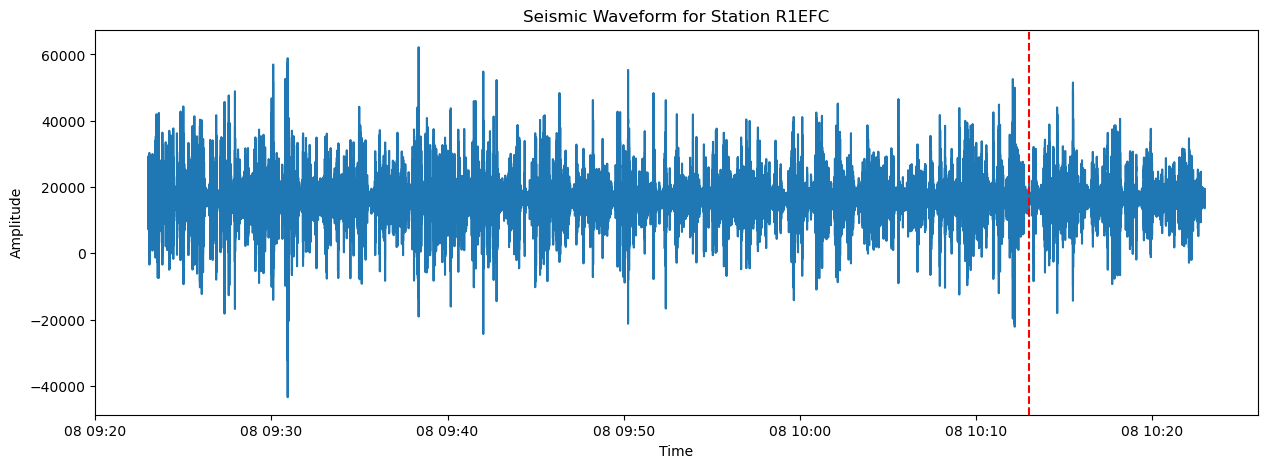

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert UTCDateTime to pandas Timestamp
start_time = pd.to_datetime(str(ShakeDatadf['Start Time'][0]))

# Generate time series for x-axis
times = pd.date_range(start=start_time, periods=len(ShakeDatadf['Samples'][0]), freq=f'{1/ShakeDatadf["Sampling Rate"][0]}S')
# Make sure usgs_df.time[0] is a pandas Timestamp
vertical_line_time = pd.to_datetime(usgs_df.time[0]) 


# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(times, ShakeDatadf['Samples'][0])
plt.axvline(x=vertical_line_time, color='r', linestyle='--')  # Adds a red dashed vertical line at the given time
plt.title(f"Seismic Waveform for Station {ShakeDatadf['Station'][0]}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [12]:
%%time
len(ShakeDatadf['Samples'][0]) 

CPU times: total: 0 ns
Wall time: 1 ms


360001

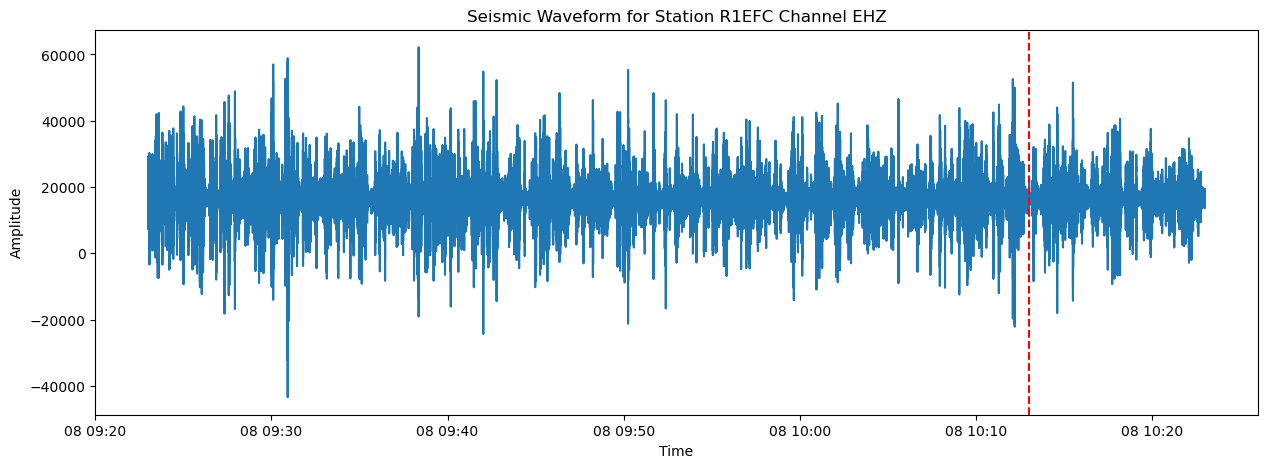

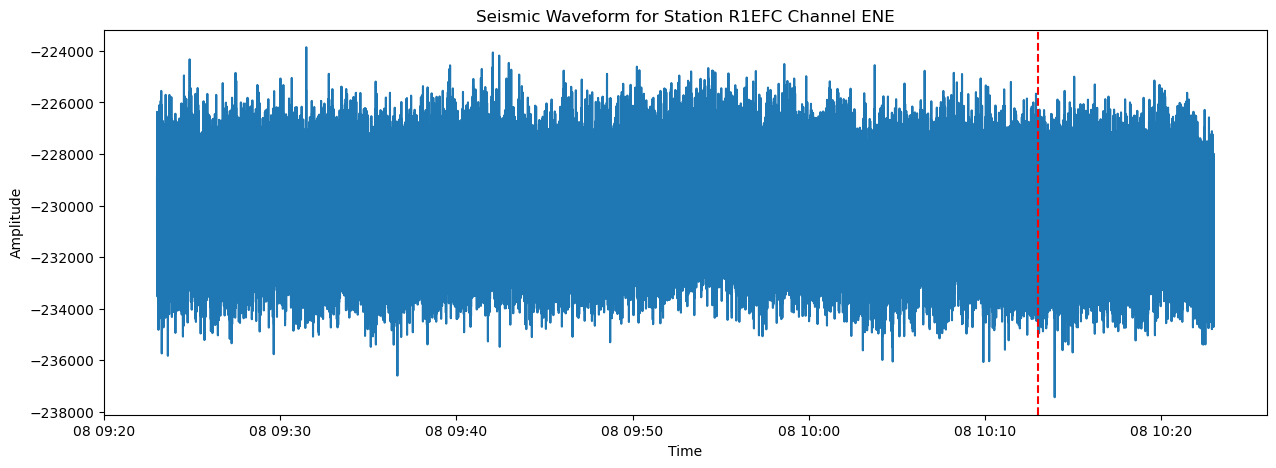

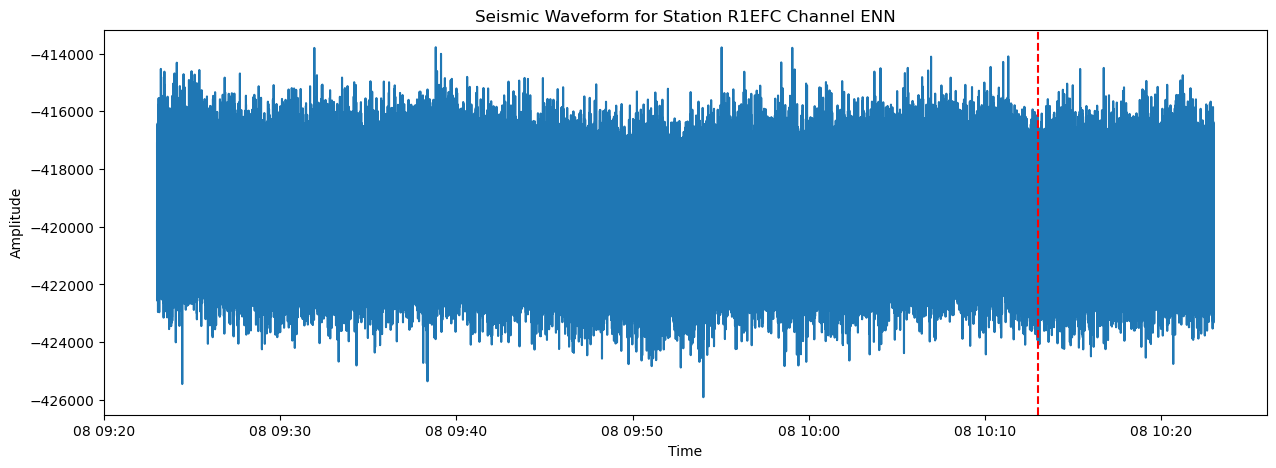

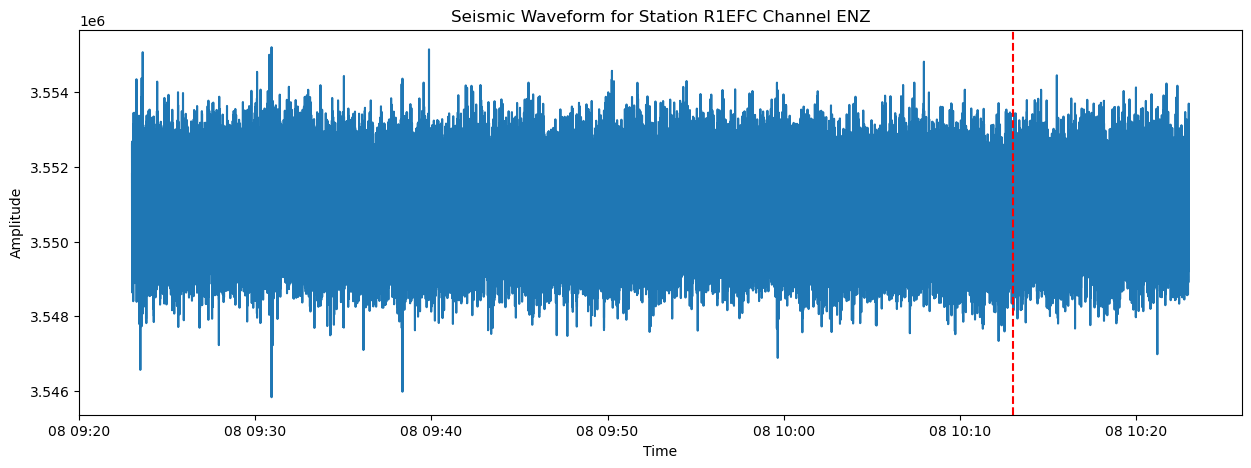

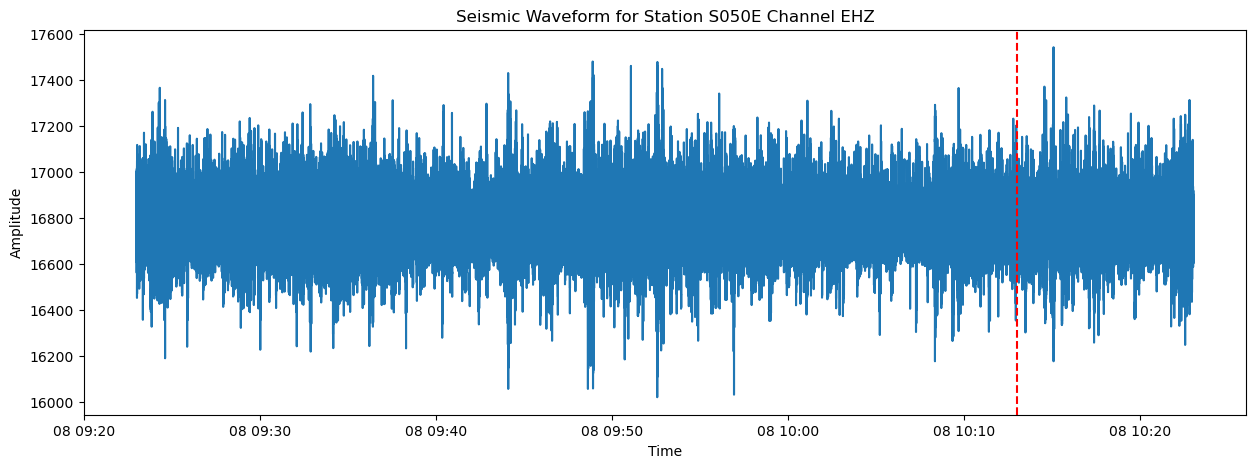

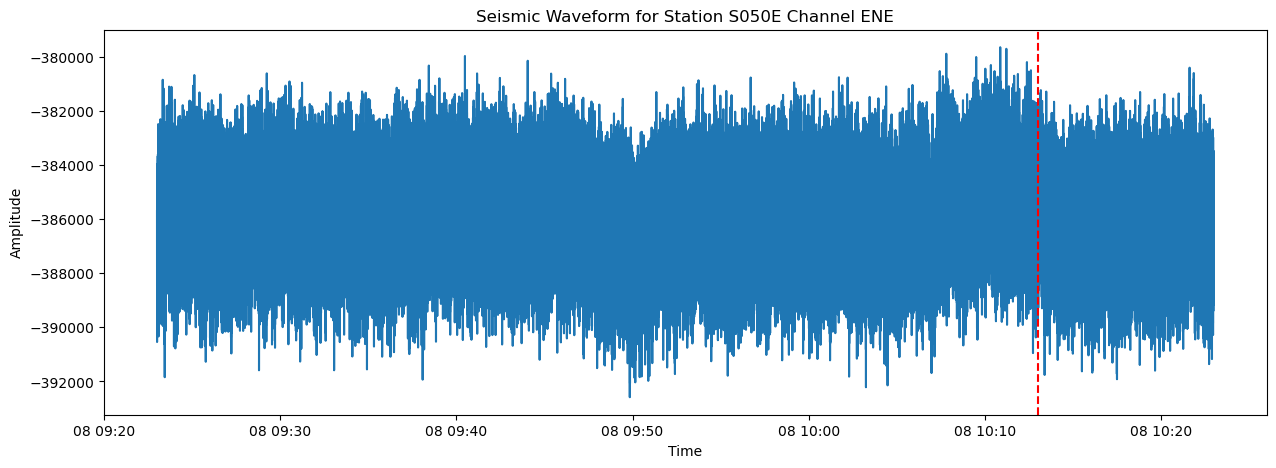

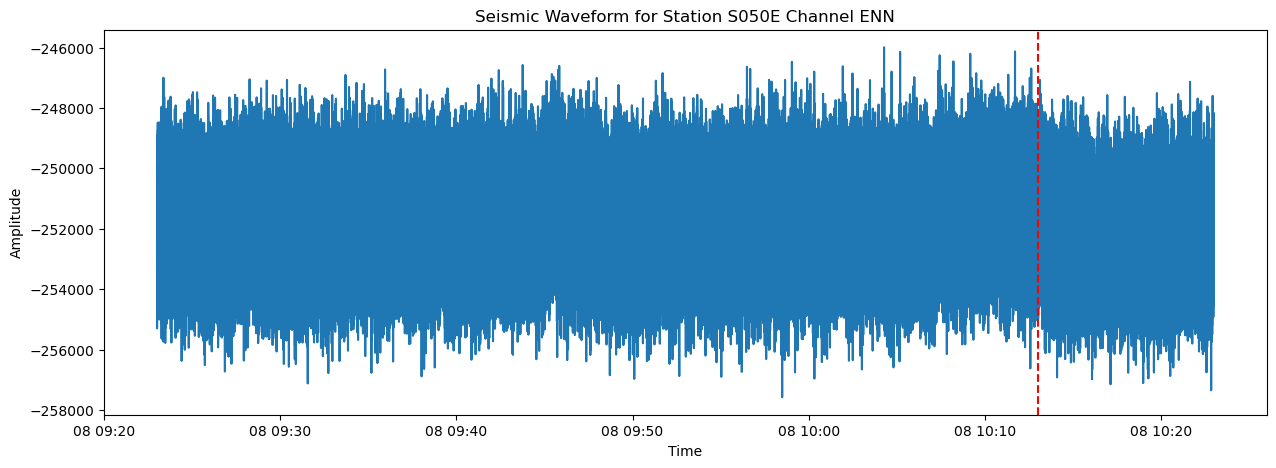

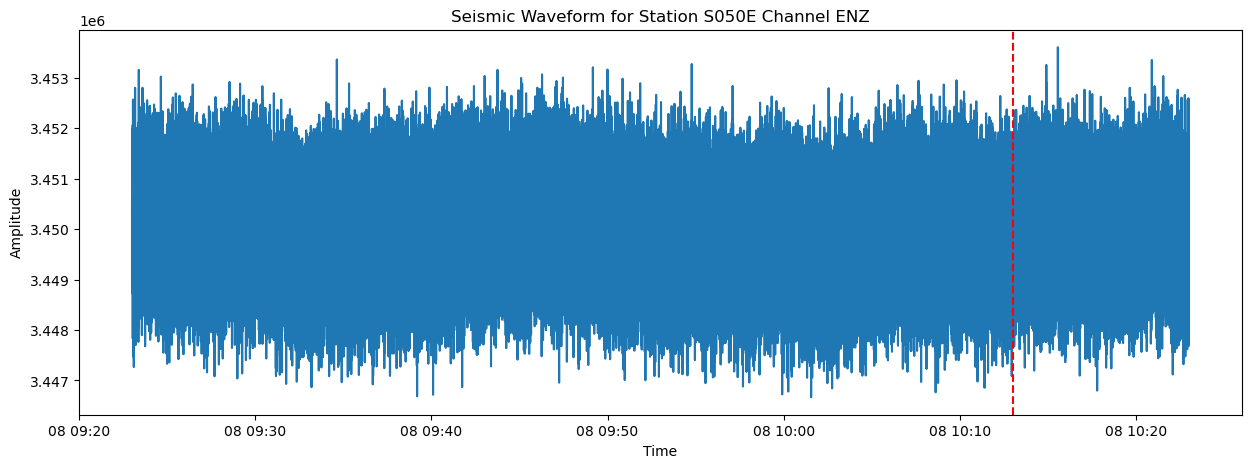

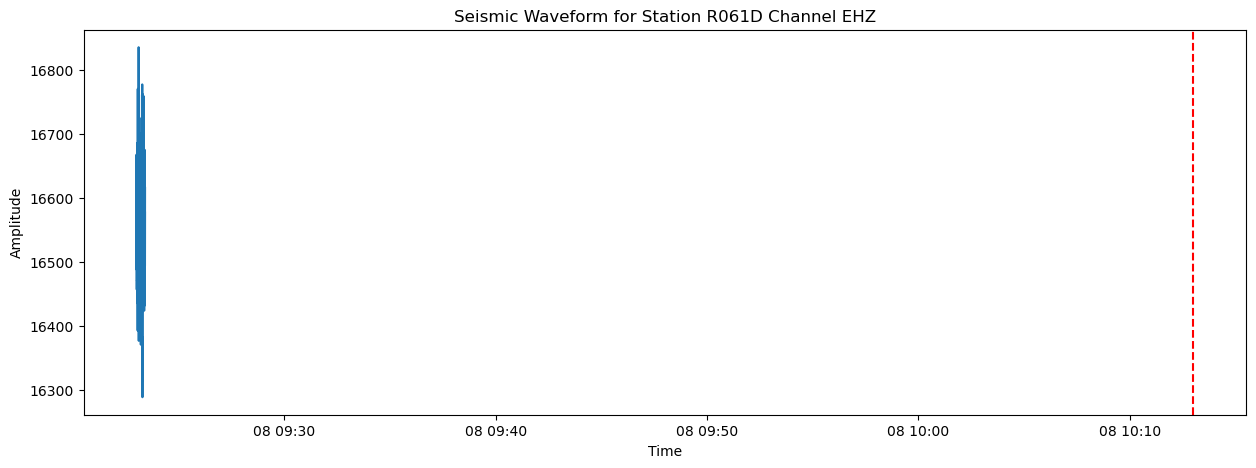

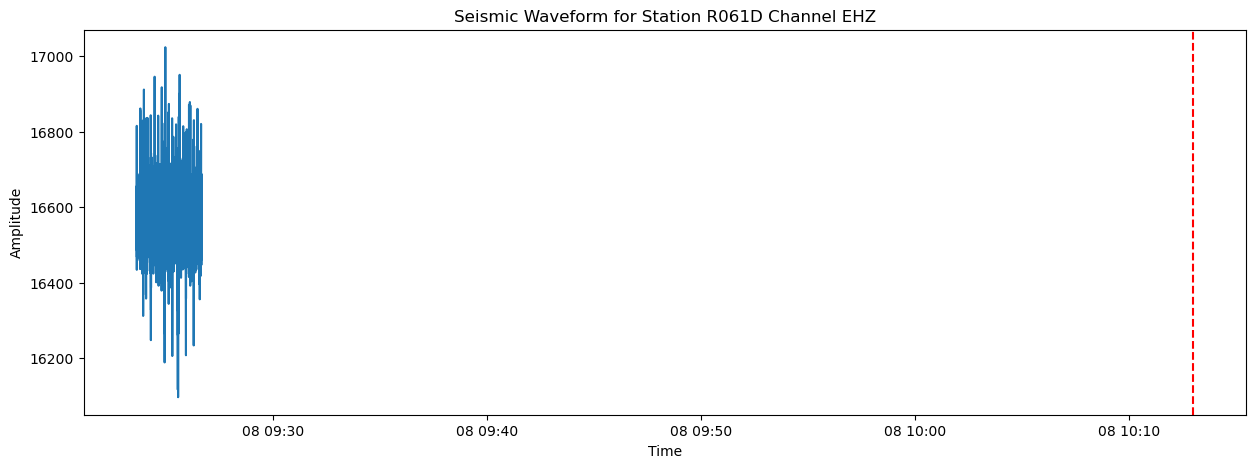

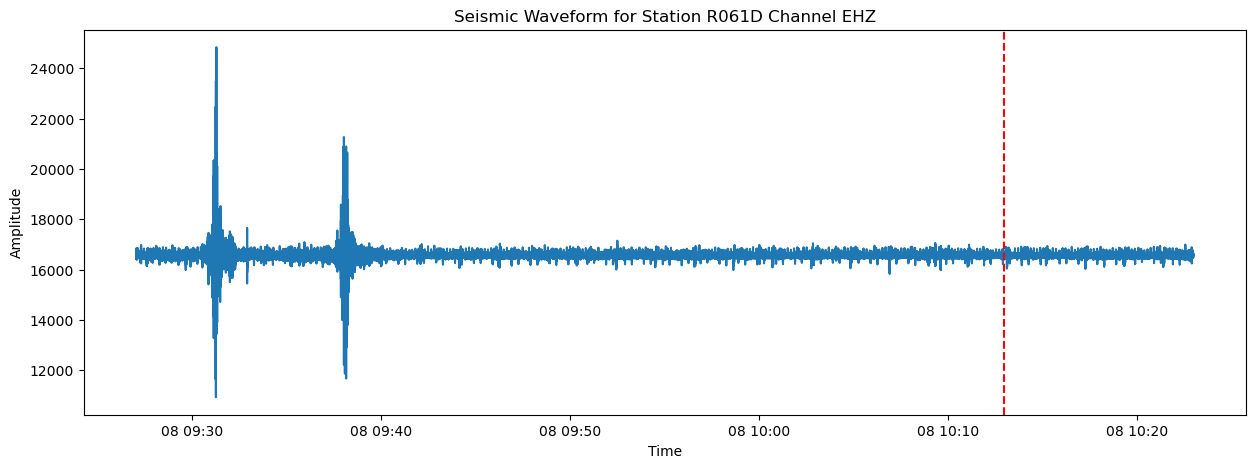

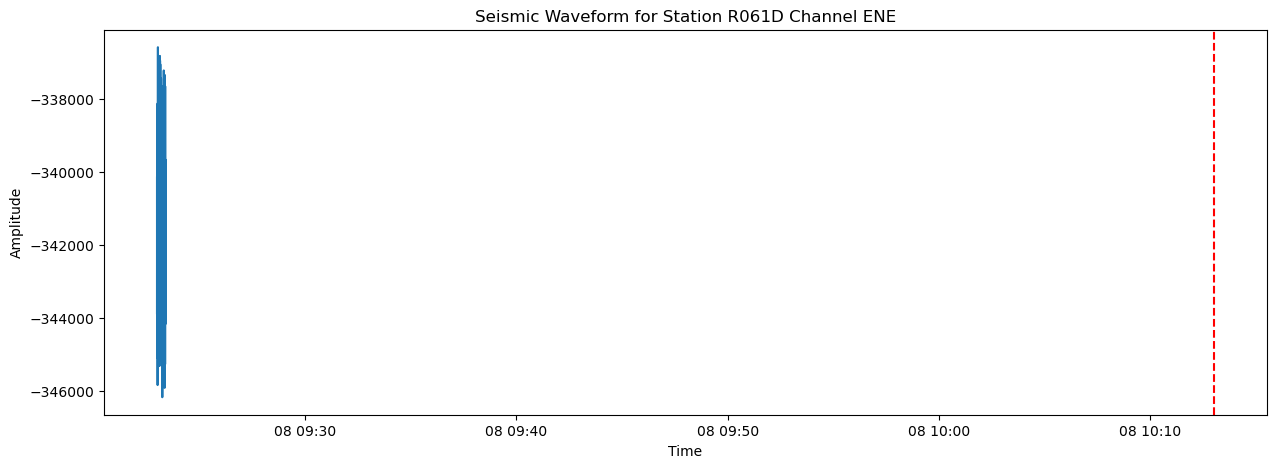

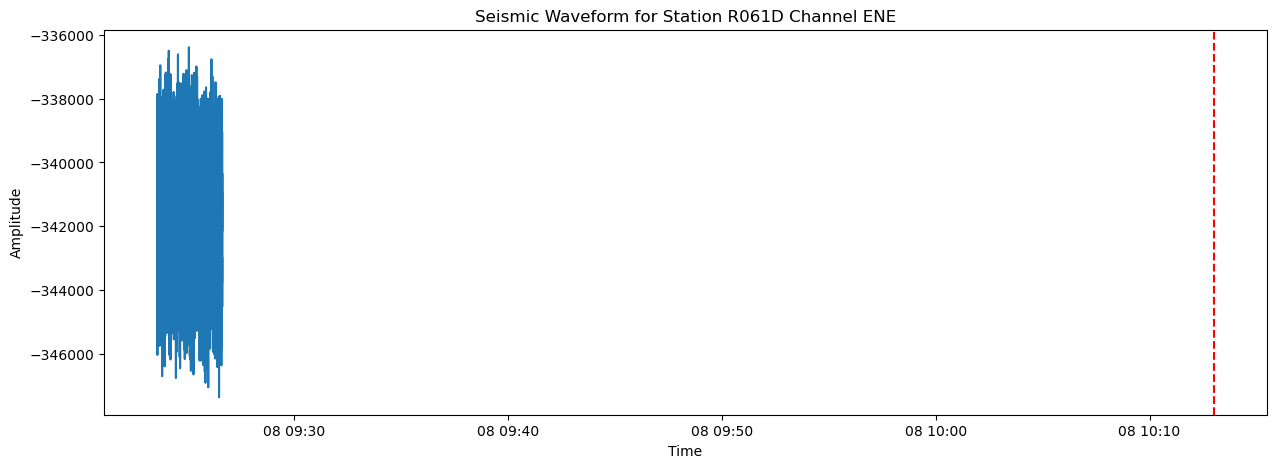

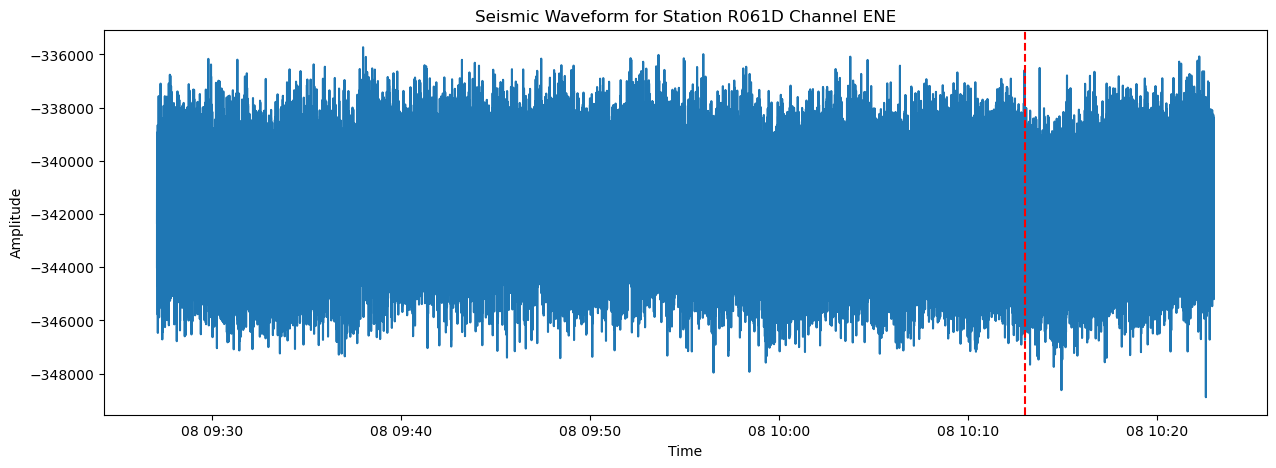

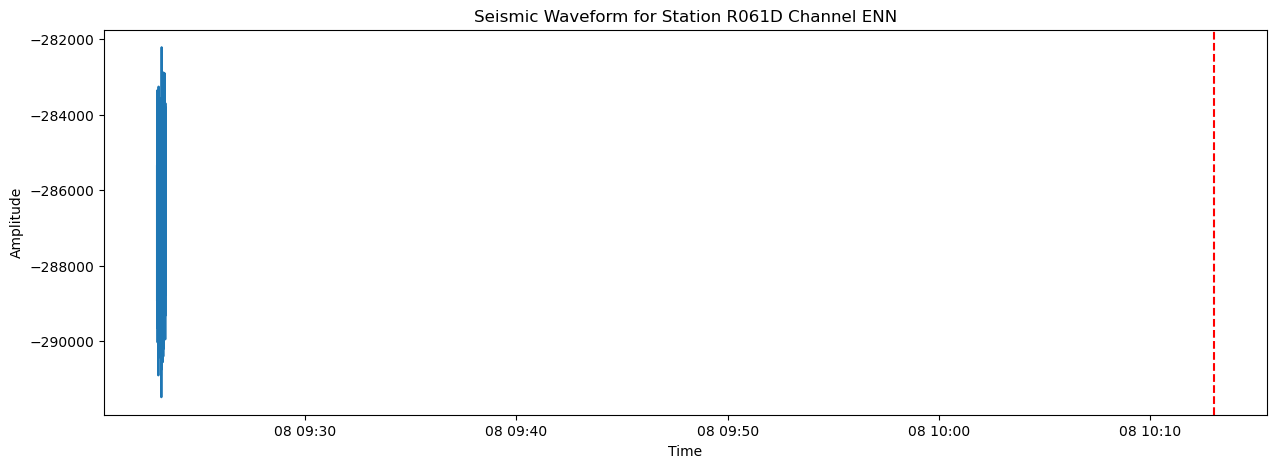

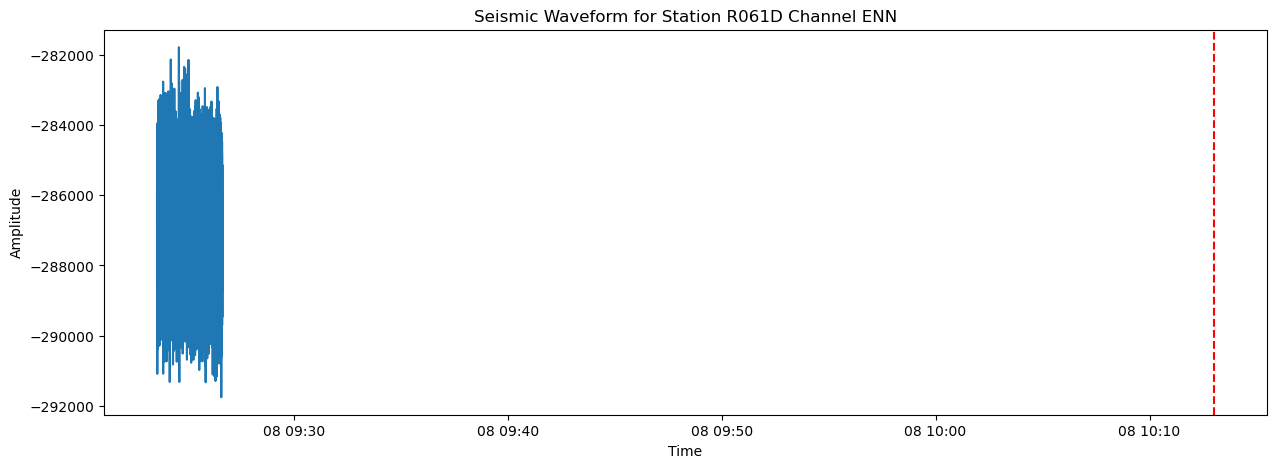

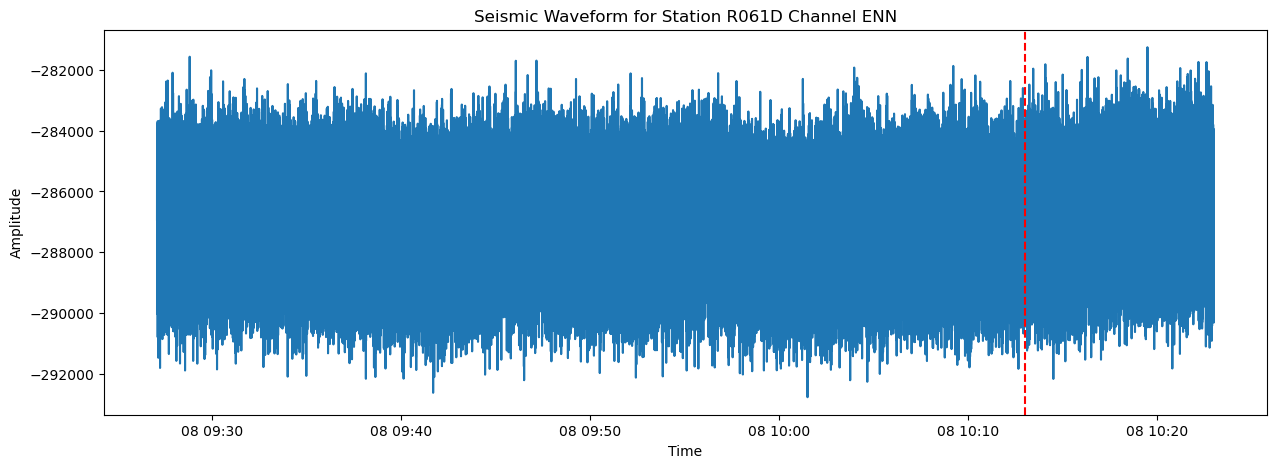

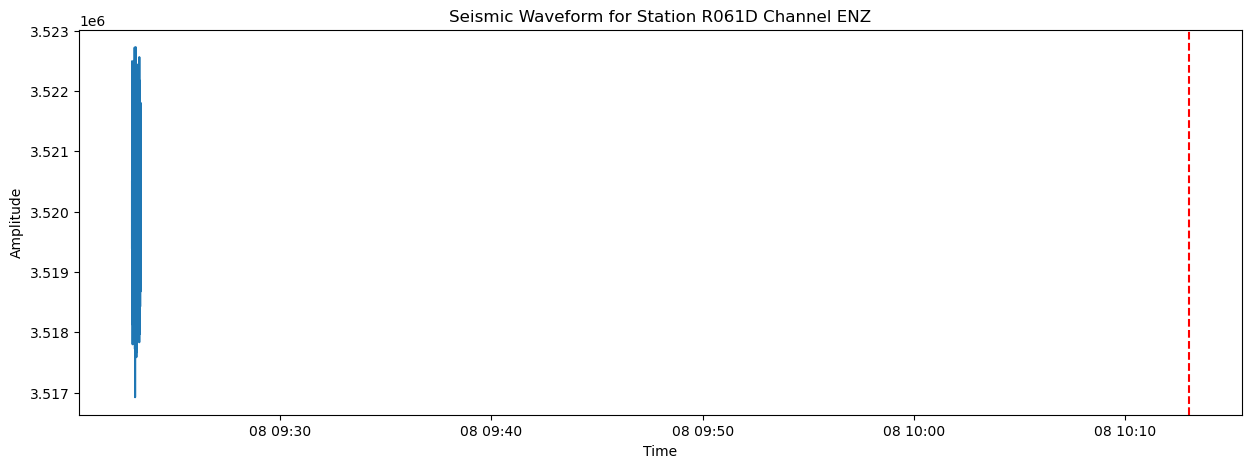

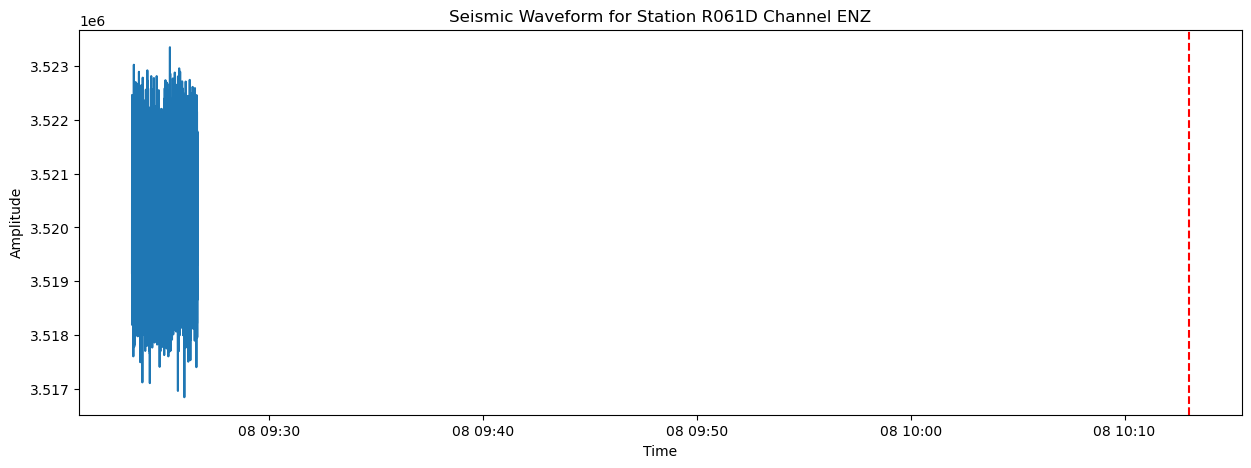

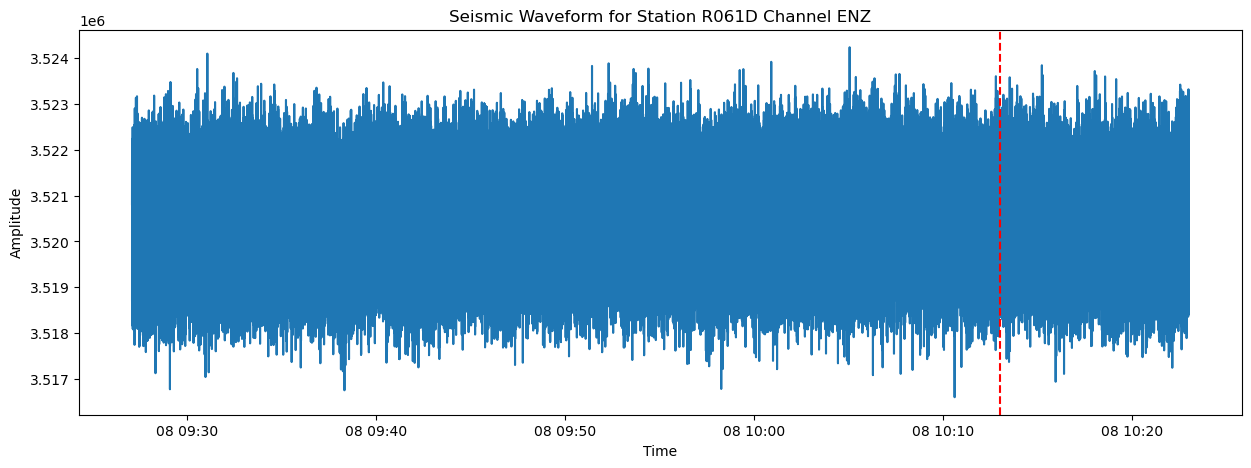

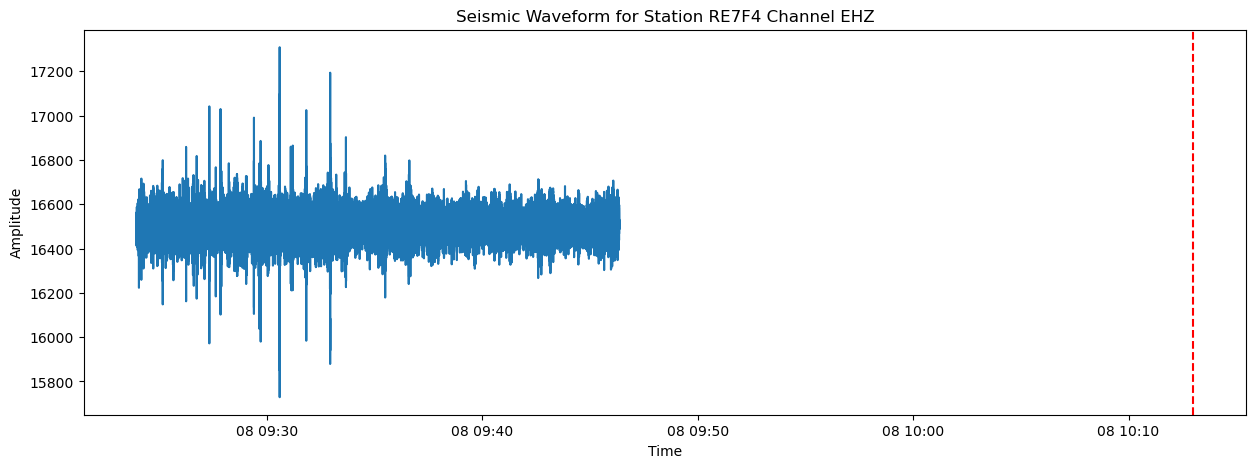

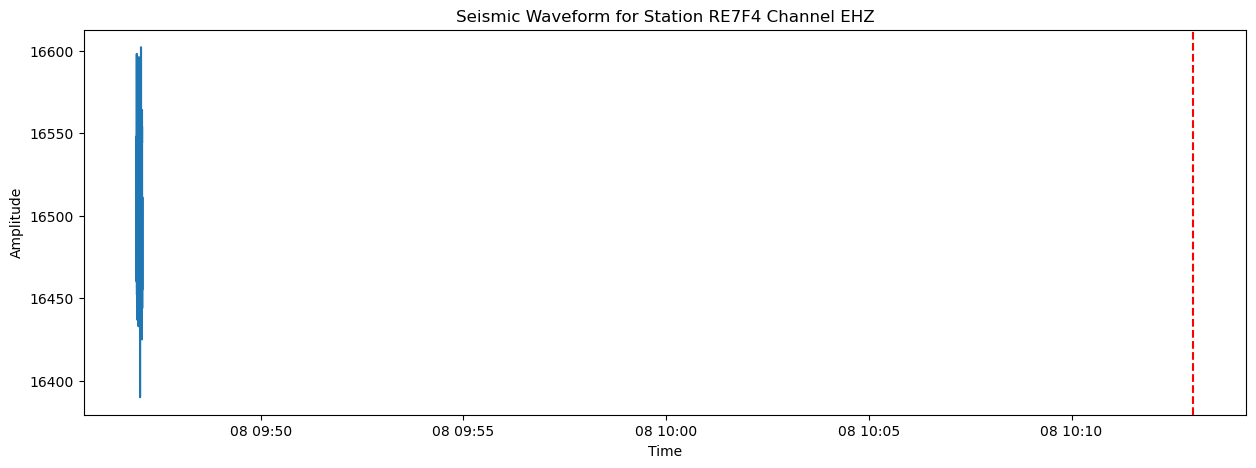

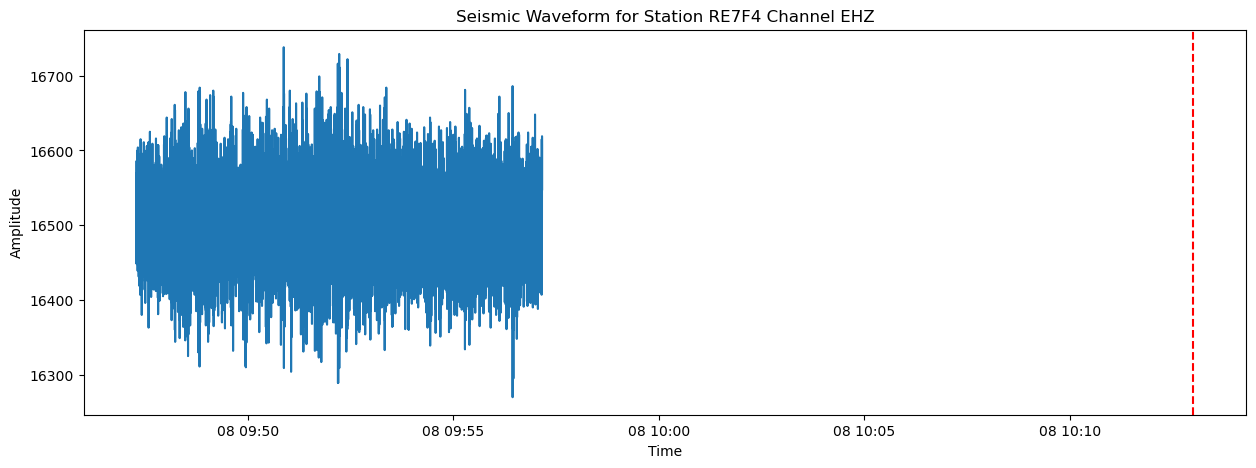

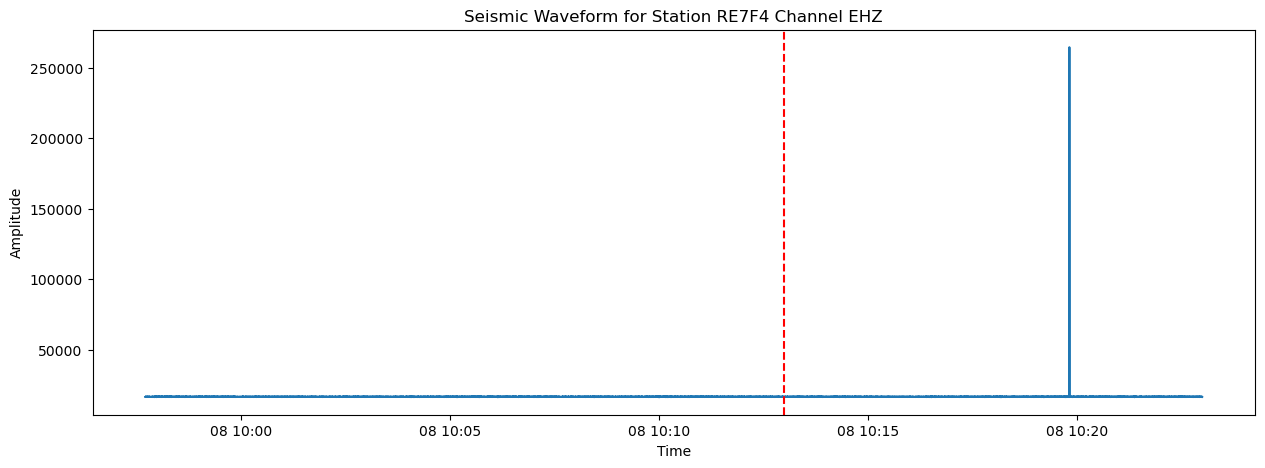

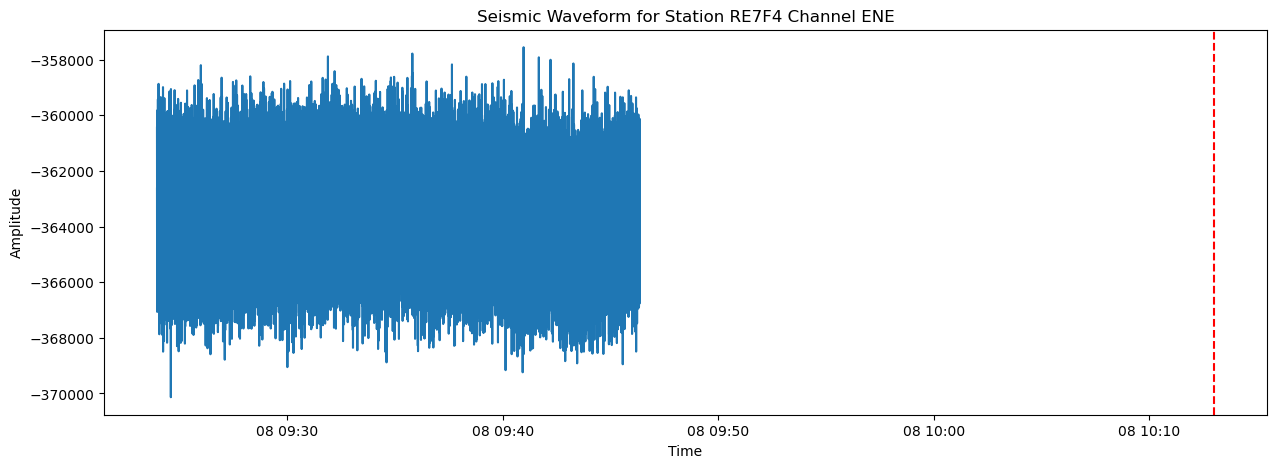

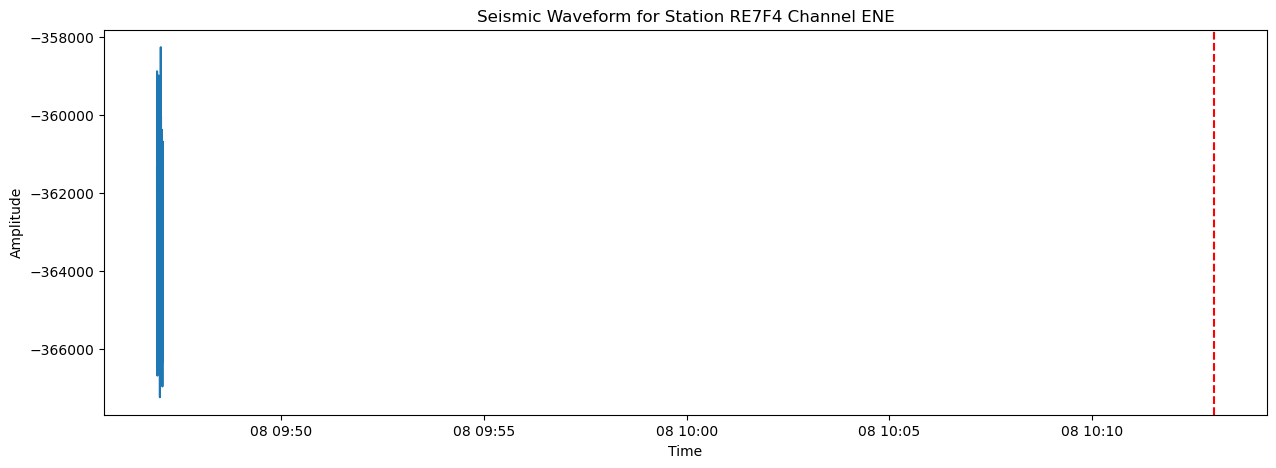

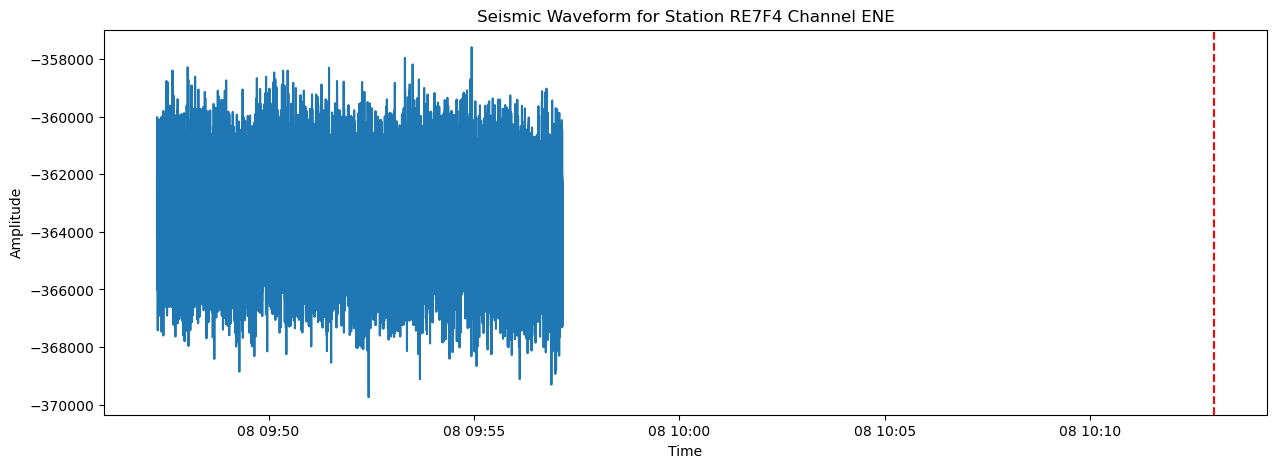

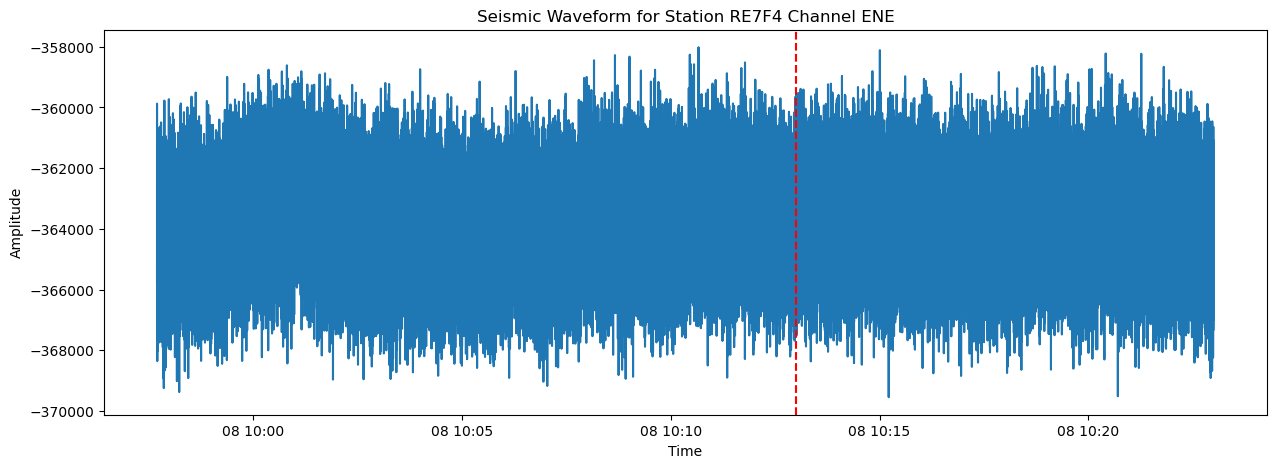

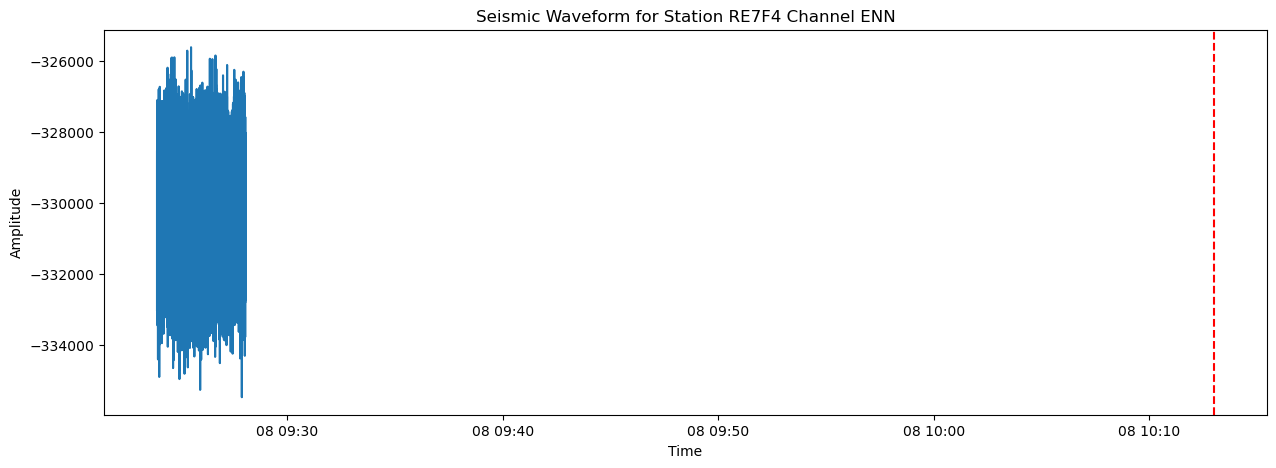

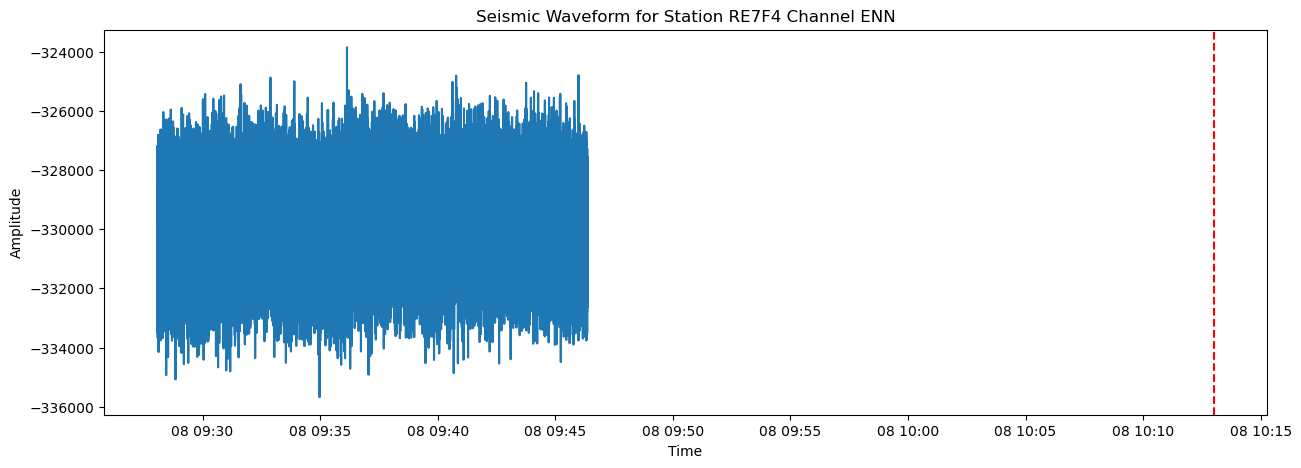

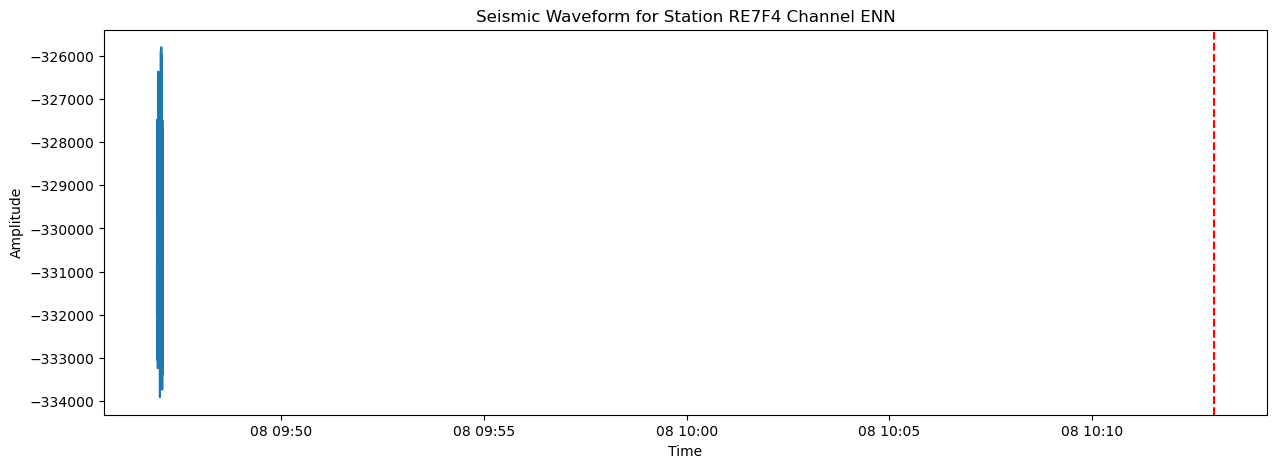

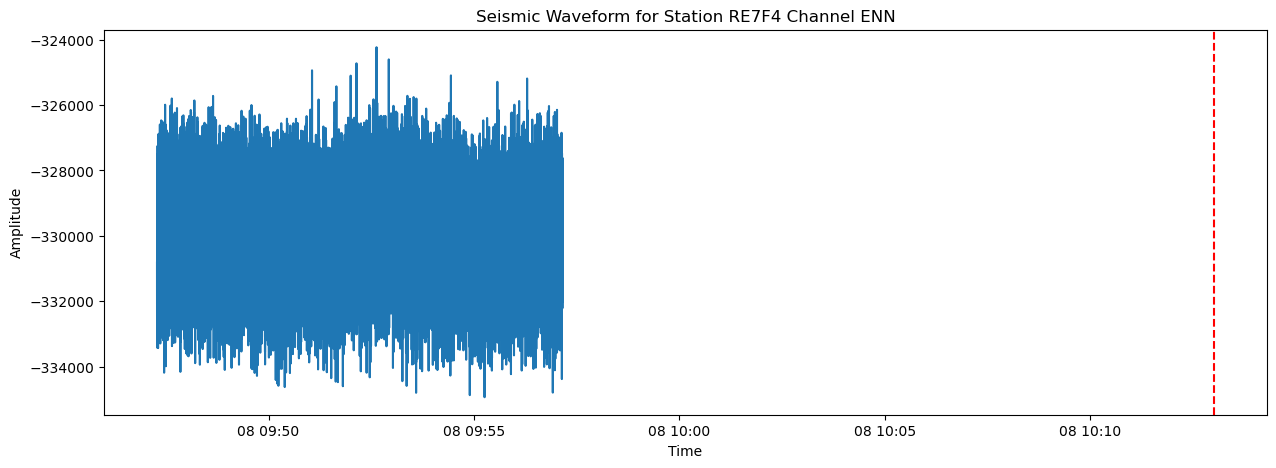

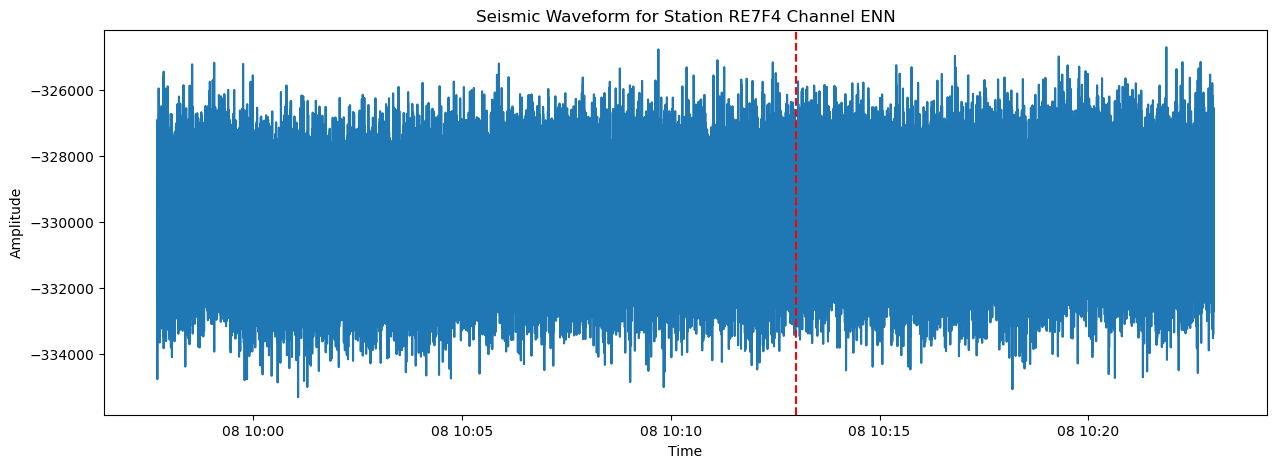

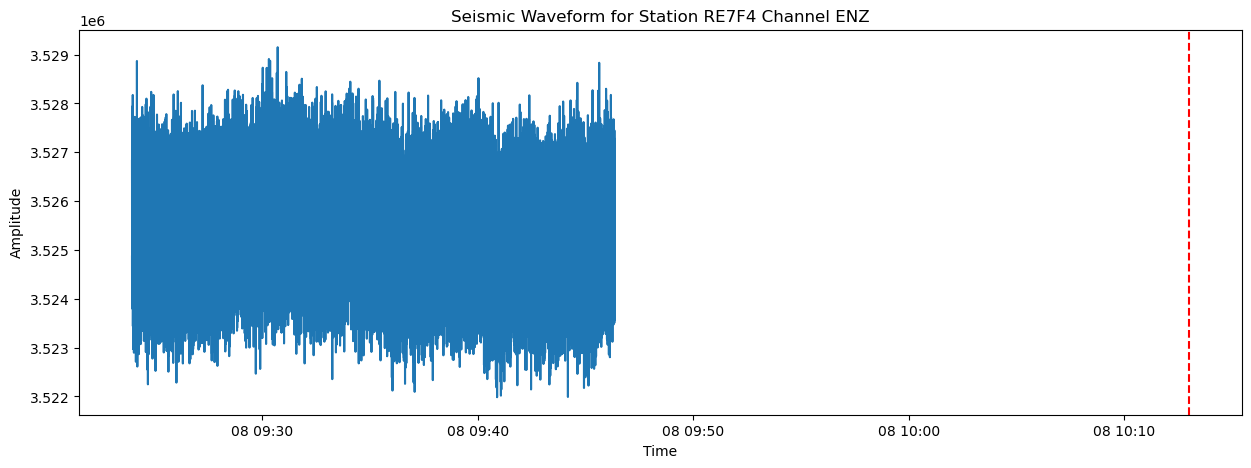

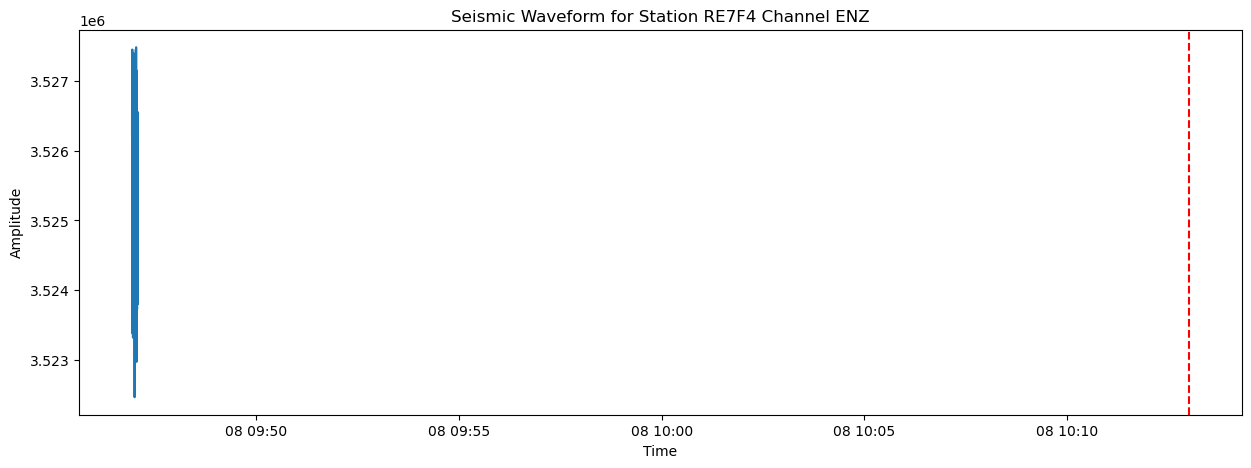

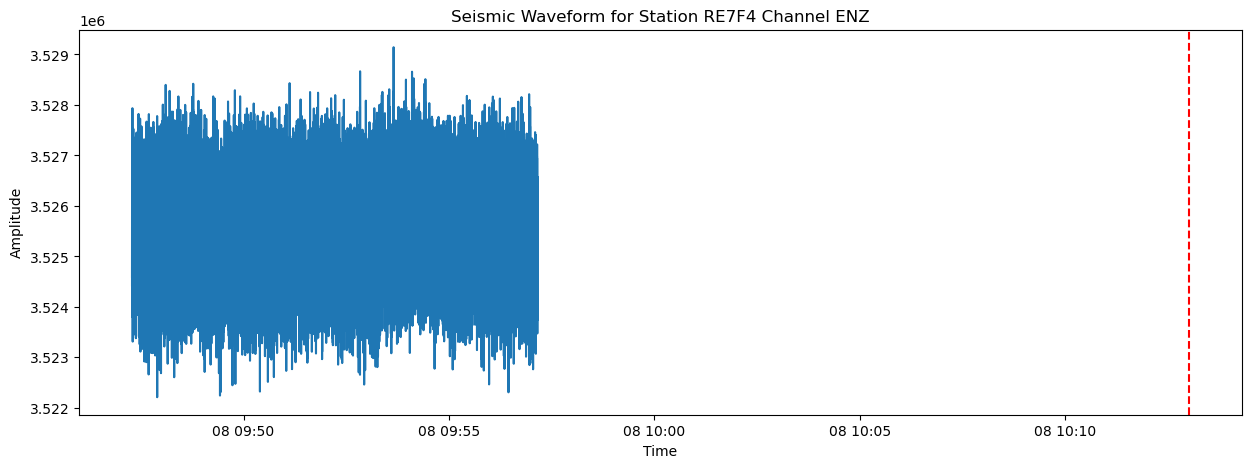

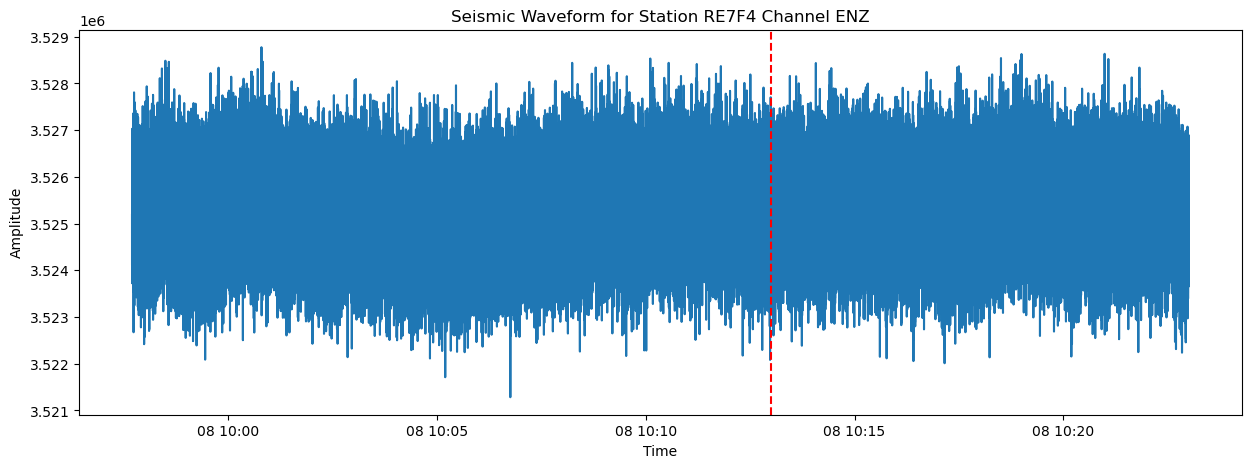

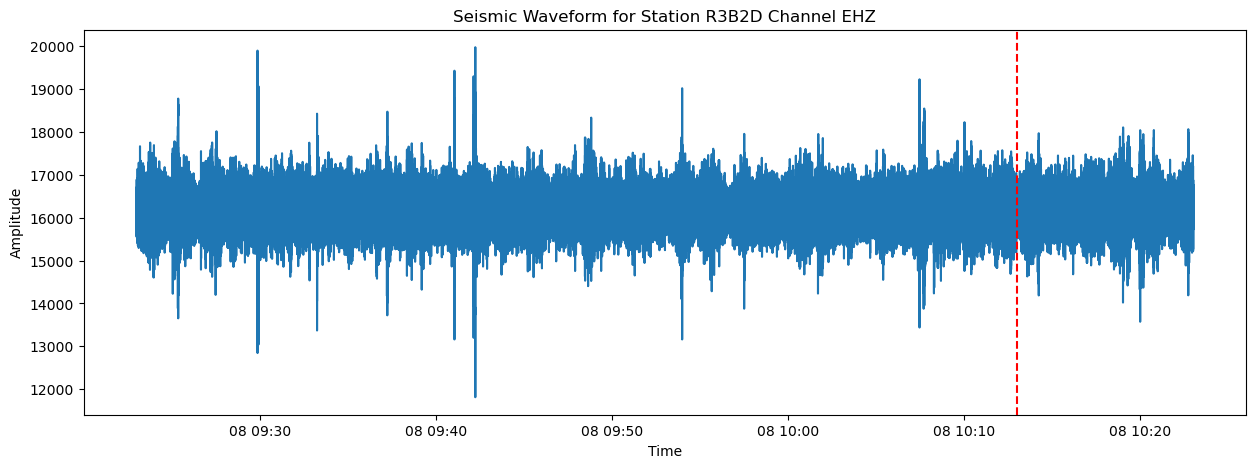

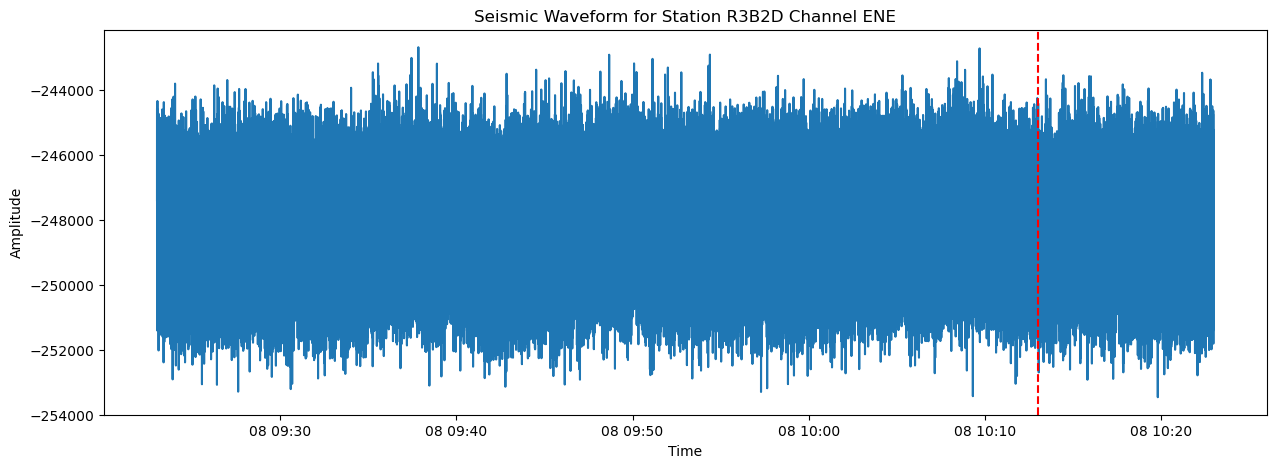

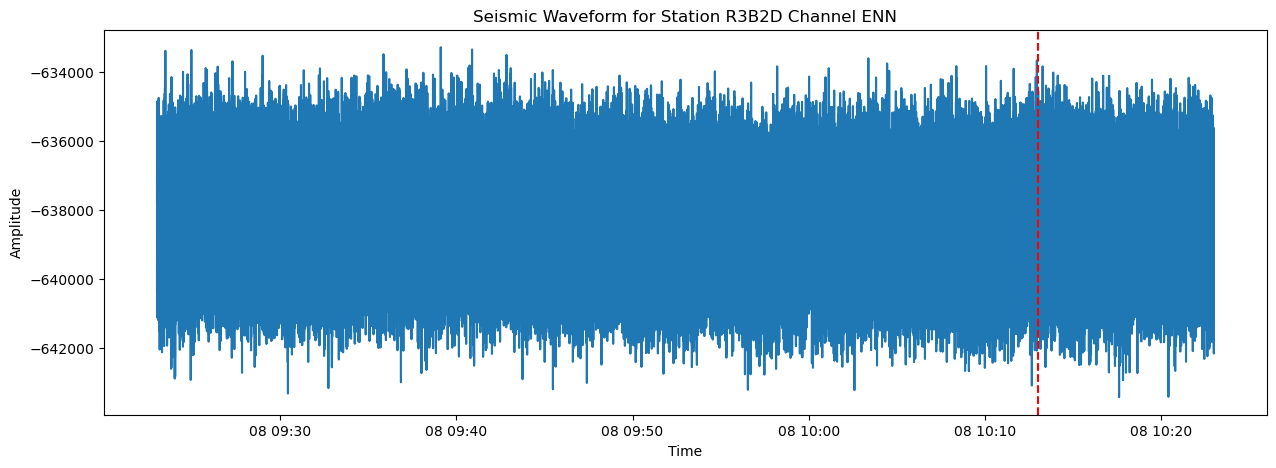

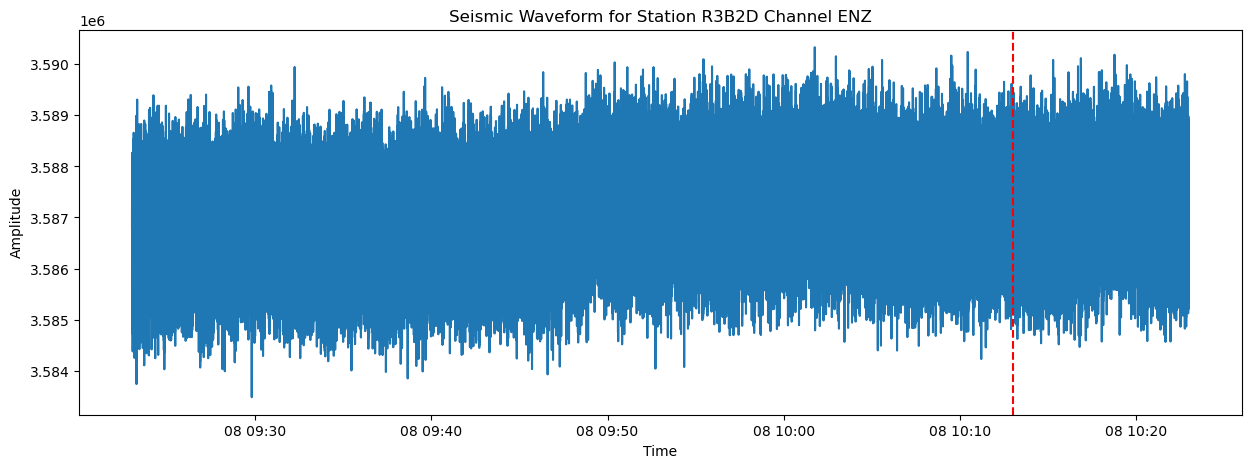

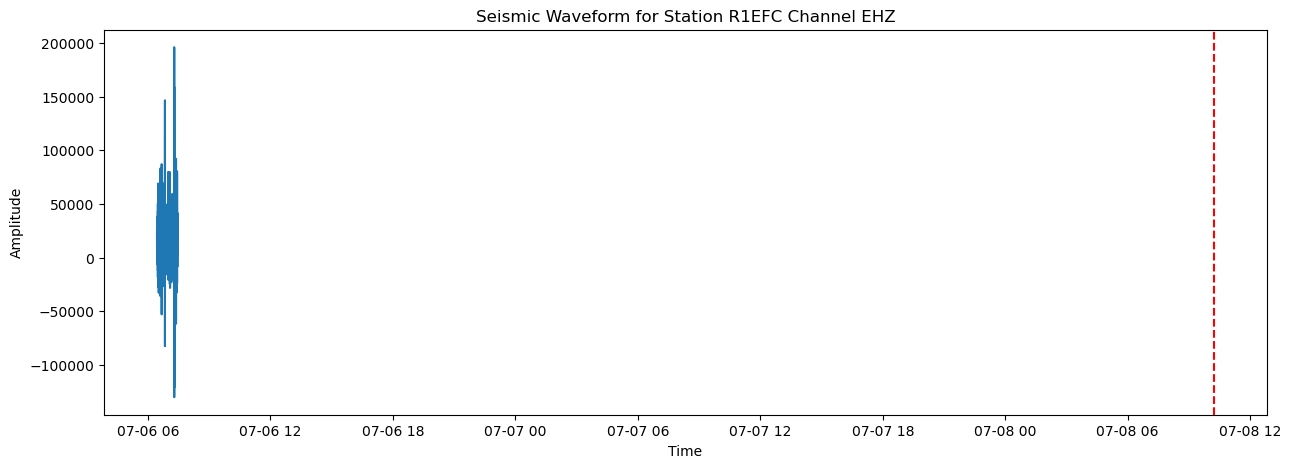

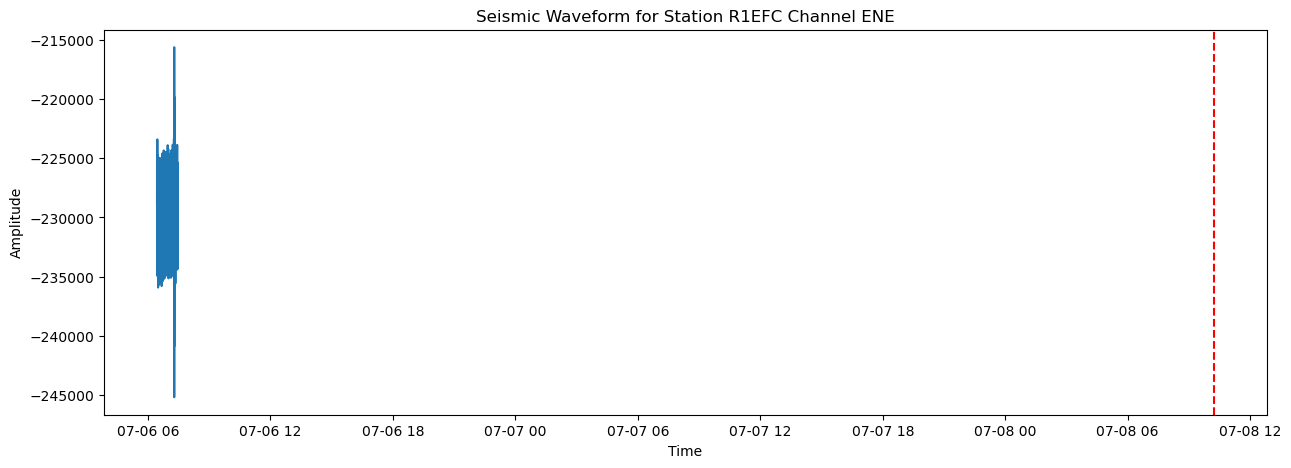

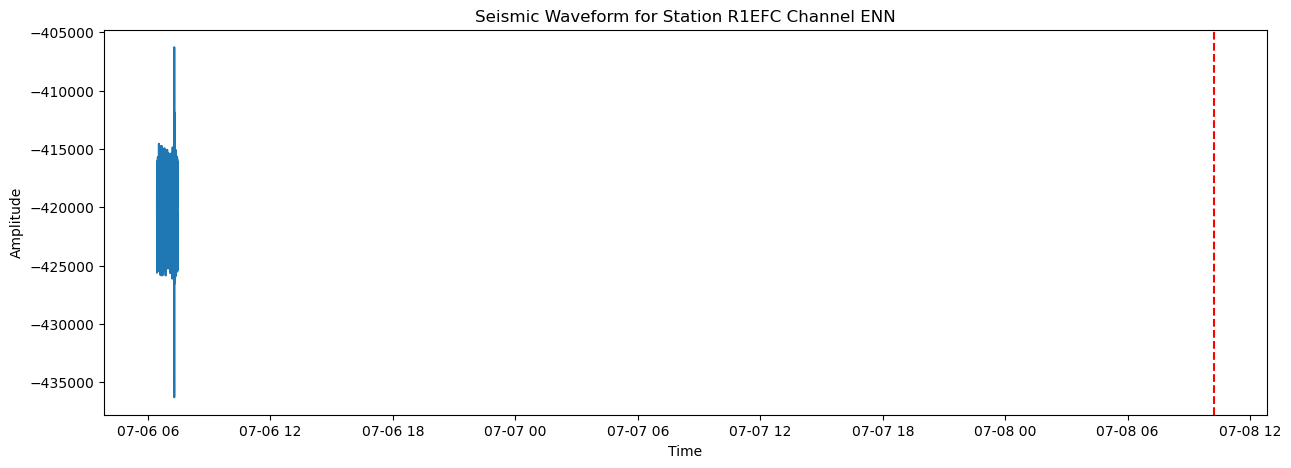

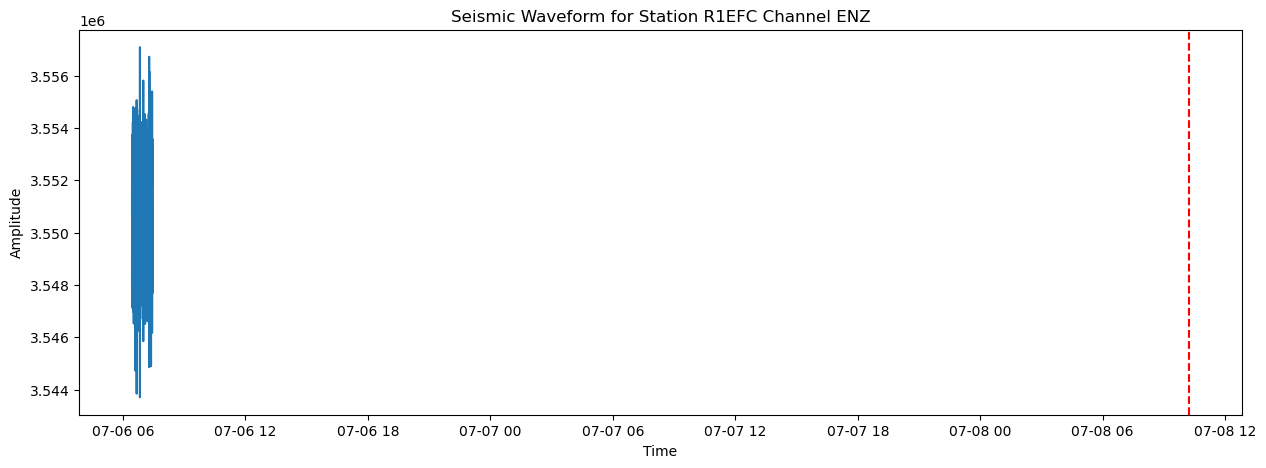

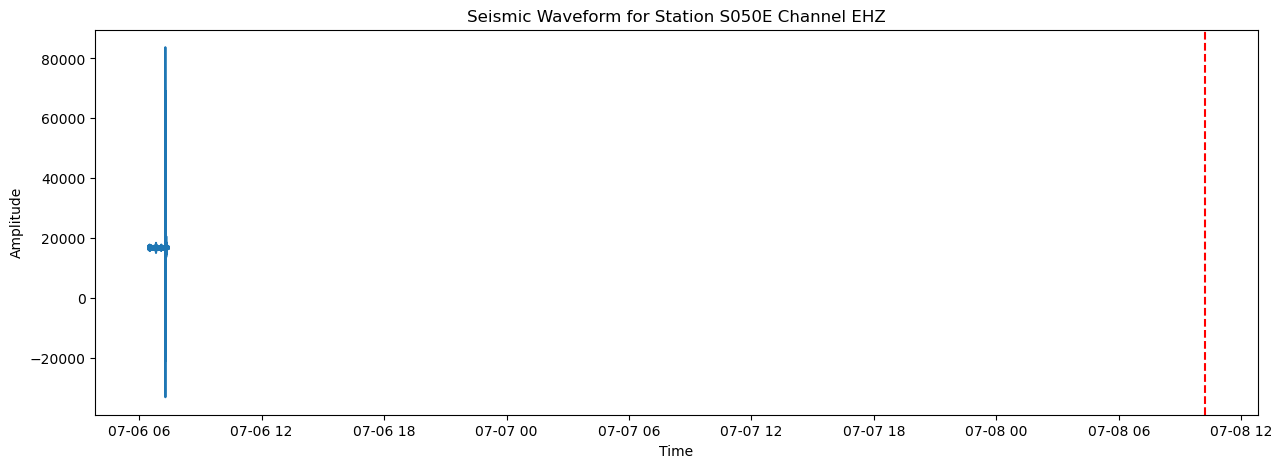

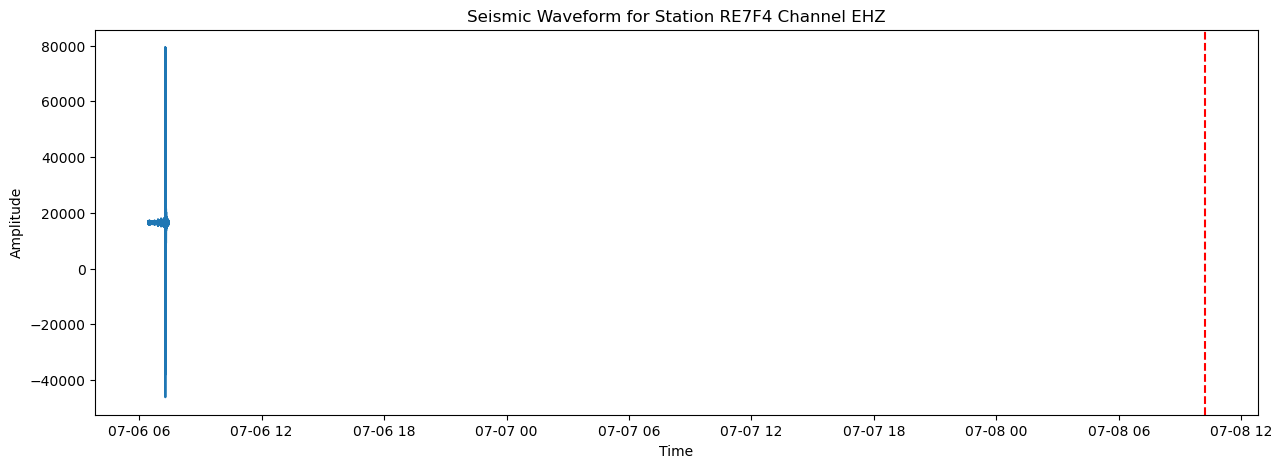

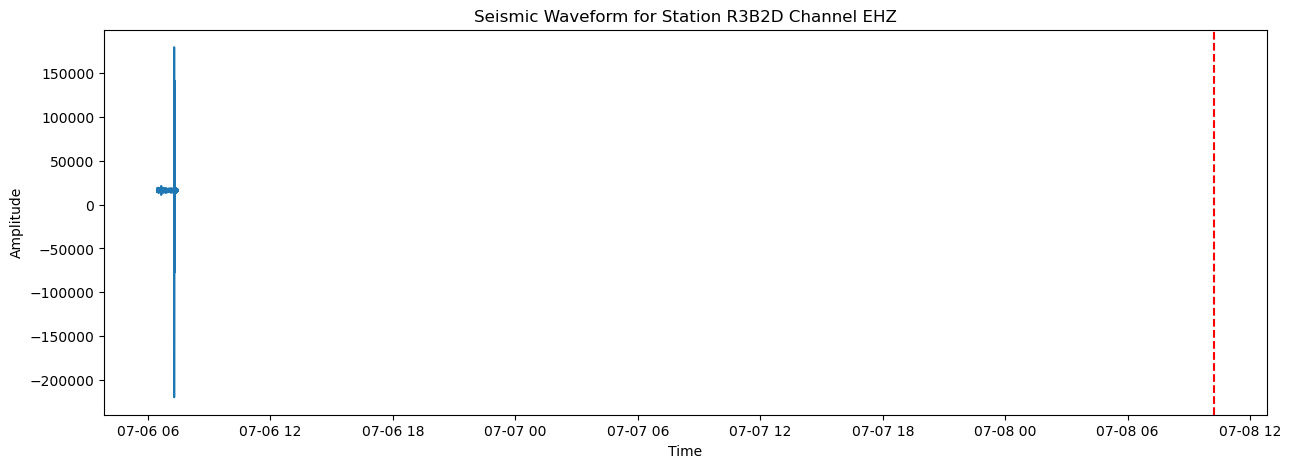

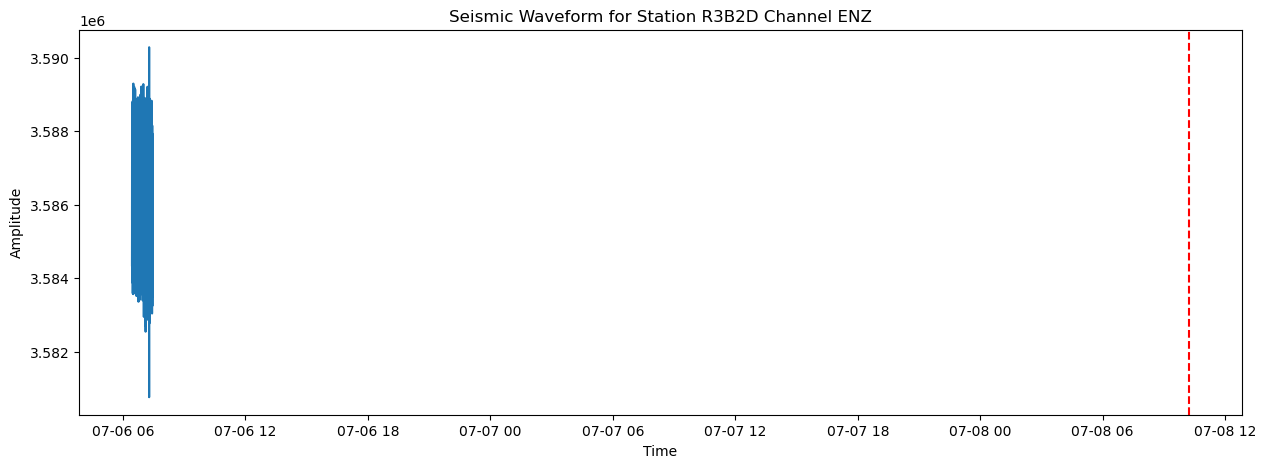

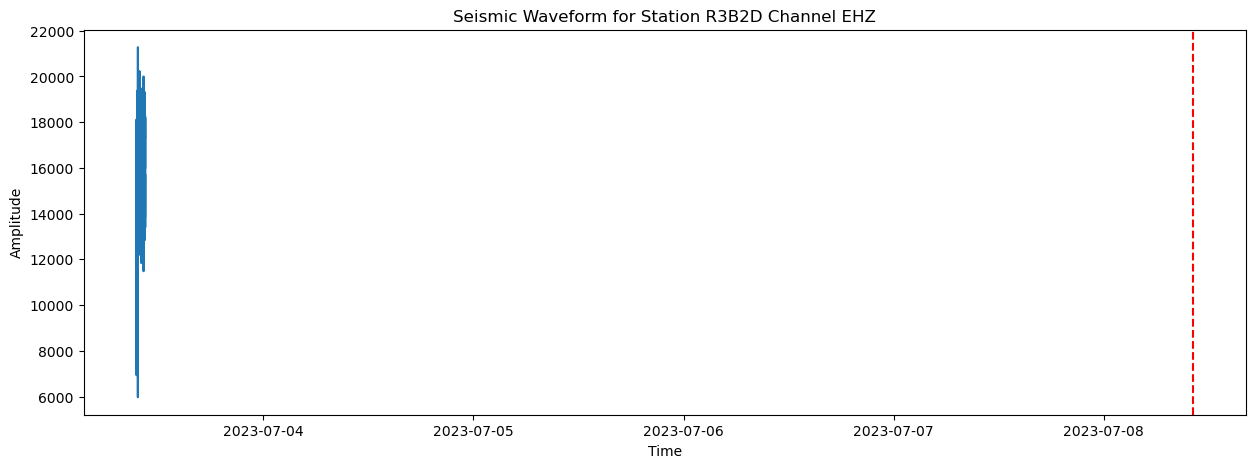

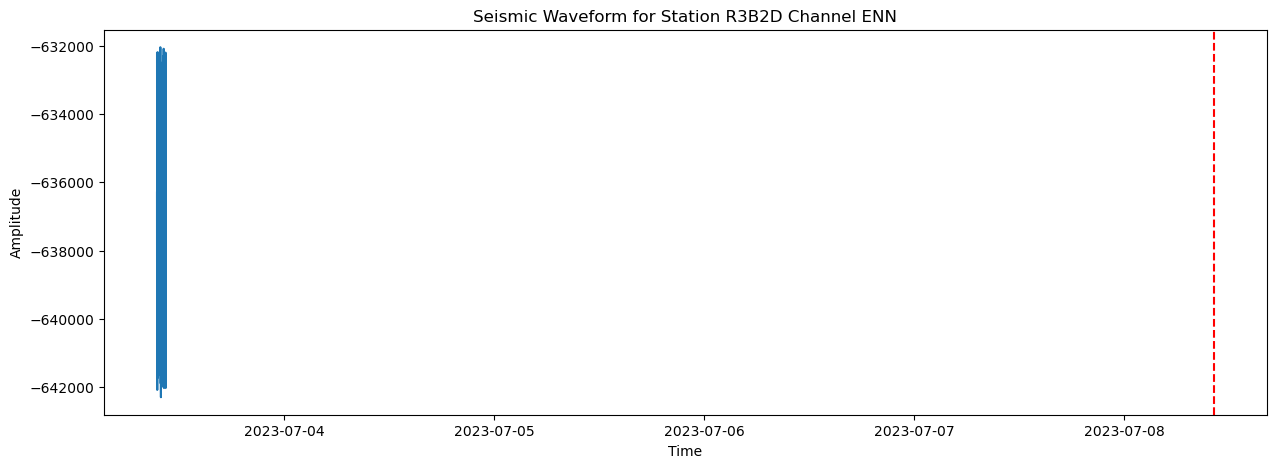

In [24]:

for index, row in ShakeDatadf.iterrows():
    # Convert UTCDateTime to pandas Timestamp for start time
    start_time = pd.to_datetime(str(row['Start Time']))

    # Generate time series for x-axis based on sampling rate and number of samples
    times = pd.date_range(start=start_time, periods=len(row['Samples']), freq=f'{1/row["Sampling Rate"]}S')
    
    # Make sure usgs_df.time[0] is a pandas Timestamp
    vertical_line_time = pd.to_datetime(usgs_df.time[0])
    
    # Plot the waveform
    plt.figure(figsize=(15, 5))
    plt.plot(times, row['Samples'])
    plt.axvline(x=vertical_line_time, color='r', linestyle='--')  # Adds a red dashed vertical line at the given time
    plt.title(f"Seismic Waveform for Station {row['Station']} Channel {row['Channel']}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    
    # Save the figure with a unique name if needed
    #plt.savefig(f"Station_{row['Station']}_Channel_{row['Channel']}_Index_{index}.png")
    
    plt.show() # Show the plot
    plt.close() # Close the plot to avoid overwriting

In [26]:
X = pd.DataFrame(ShakeDatadf['Samples'].tolist())

In [28]:
X.shape

(51, 360001)

In [27]:
X

,0,1,2,3,4,5,6,7,8,9,...,359991,359992,359993,359994,359995,359996,359997,359998,359999,360000
0,21881,19147,16274,13169,10757,9854,9788,11381,14752,18464,...,17149.0,16757.0,16358.0,16379.0,16498.0,17044.0,17384.0,17359.0,17023.0,16243.0
1,-228925,-230895,-228941,-232004,-230021,-226559,-227507,-229960,-230417,-231227,...,-231217.0,-232507.0,-232422.0,-231595.0,-228877.0,-229389.0,-229247.0,-227994.0,-232042.0,-231461.0
2,-419812,-421361,-419725,-420480,-419110,-417727,-419483,-419566,-420479,-420050,...,-420951.0,-420966.0,-420102.0,-420506.0,-420029.0,-418414.0,-416436.0,-416598.0,-419539.0,-420902.0
3,3551805,3551044,3551469,3550168,3551019,3552622,3552491,3551732,3550798,3551291,...,3551217.0,3551293.0,3549507.0,3550202.0,3551847.0,3552357.0,3553146.0,3552159.0,3550106.0,3549369.0
4,16836,16837,16924,16917,16867,16880,16939,17003,16922,16884,...,16915.0,16862.0,16748.0,16719.0,16733.0,16732.0,16730.0,16714.0,16707.0,16731.0
5,-385705,-387595,-388670,-386749,-386174,-387211,-385962,-387617,-387575,-388983,...,-387086.0,-386418.0,-385369.0,-385539.0,-387376.0,-388106.0,-388060.0,-387108.0,-384606.0,-384033.0
6,-252445,-252639,-253862,-252992,-252938,-252259,-252636,-251082,-249885,-251431,...,-253300.0,-252198.0,-252802.0,-252928.0,-252607.0,-253724.0,-252371.0,-252362.0,-251970.0,-251415.0
7,3450594,3449527,3449952,3449744,3449000,3449378,3450117,3450045,3449531,3449077,...,3449454.0,3450113.0,3449292.0,3449744.0,3449003.0,3448977.0,3450338.0,3450145.0,3450134.0,3450666.0
8,16598,16591,16555,16523,16592,16625,16557,16558,16595,16651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,16586,16555,16532,16593,16632,16586,16626,16655,16617,16567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Doing Basic Principle Component Analysis

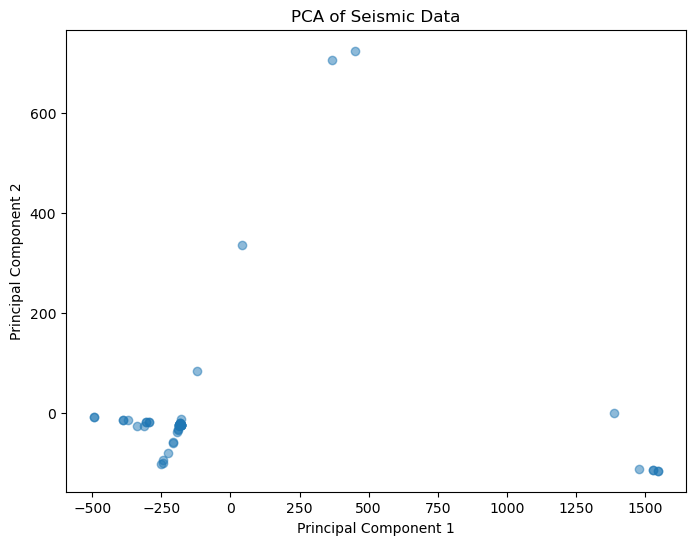

In [25]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# This is a computationally expensive step and may require optimization
X = pd.DataFrame(ShakeDatadf['Samples'].tolist())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.fillna(0))  # Fill NA values if any

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Optionally, get the explained variance to see how much info is compressed into the principal components
explained_variance = pca.explained_variance_ratio_

# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Seismic Data')
plt.show()

What the plot suggests:

Spread of Data Points: The data points are spread out over the principal component space, which suggests varying degrees of correlation among the original features.

Outliers: There seem to be some data points that are far away from the others. These could be outliers or unusual observations that could be of particular interest.

Clusters: If you notice clusters of points, these might indicate groups of similar observations. In the context of seismic data, clusters could potentially represent similar seismic events or noise patterns.

C:\Users\HawkEyERio\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HawkEyERio\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


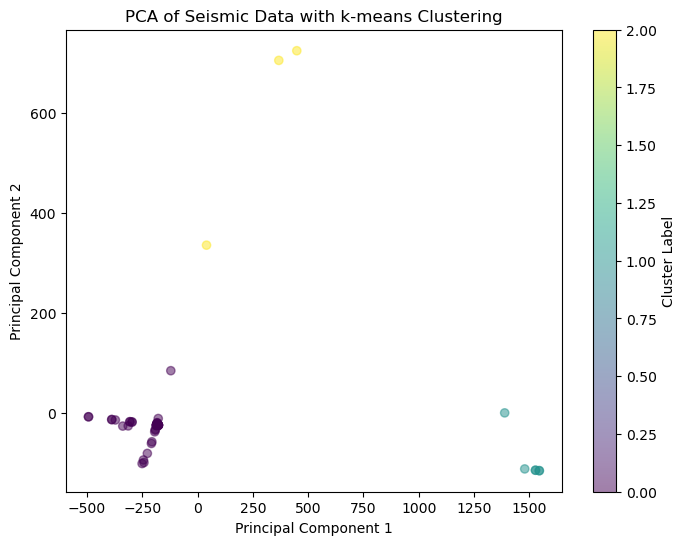

CPU times: total: 43.5 s
Wall time: 38.8 s


In [30]:
%%time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

X = pd.DataFrame(ShakeDatadf['Samples'].tolist())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.fillna(0))

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3)  # for example, we choose 3 clusters
X_clustered = kmeans.fit_predict(X_pca)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_clustered, alpha=0.5, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Seismic Data with k-means Clustering')
plt.colorbar(label='Cluster Label')
plt.show()

The output from your PCA with k-means clustering suggests that the algorithm has identified distinct groups within your data based on the variance captured by the principal components. The data points are plotted in the space defined by the first two principal components, and they're colored based on the cluster to which k-means assigned them.

### Doing the same with USGS data

C:\Users\HawkEyERio\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HawkEyERio\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


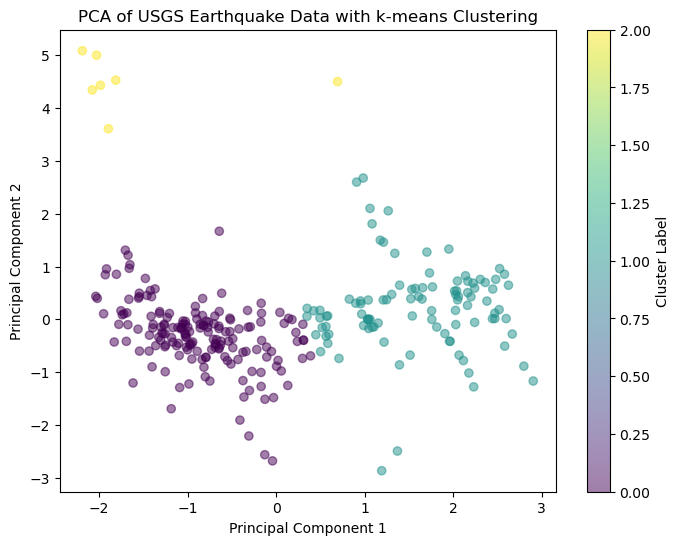

In [35]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Selecting numerical features relevant for clustering
features = ['latitude', 'longitude', 'depth', 'mag']
X = usgs_df_lim[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3)  # for example, we choose 3 clusters
X_clustered = kmeans.fit_predict(X_pca)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_clustered, alpha=0.5, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of USGS Earthquake Data with k-means Clustering')
plt.colorbar(label='Cluster Label')
plt.show()

## Trying ARIMA Time series analysis #WIP

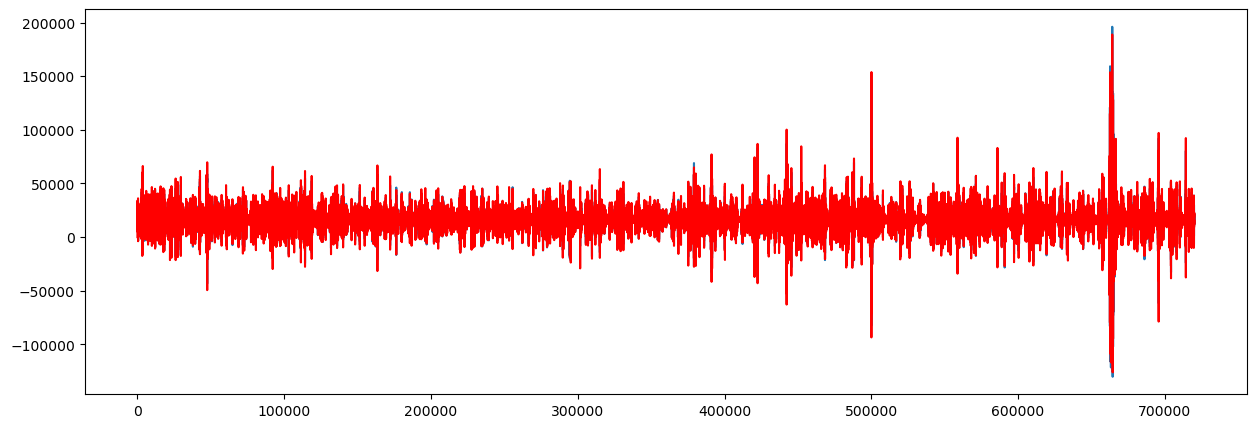

In [36]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

#loaded your Raspberry Shake data into a DataFrame
# and it's indexed by the timestamp of each sample

# Choose a station and channel to analyze
station_data = ShakeDatadf[ShakeDatadf['Station'] == 'R1EFC']
channel_data = station_data[station_data['Channel'] == 'EHZ']['Samples']

# Convert the list of samples into a time series
# Assuming the sampling rate is constant and the times are aligned with `usgs_df_lim`
time_series = np.concatenate(channel_data.values)

# Now you have a time series of amplitude values for the station and channel of interest
# Next, you can create an ARIMA model, or any other time series model, and train it
# For example, using ARIMA:

# Define the model
model = ARIMA(time_series, order=(5,1,0))  # these parameters (p,d,q) need to be optimized
model_fit = model.fit()

# You can now use this model to make predictions or look for patterns
# Let's plot the original time series with the predicted values
predictions = model_fit.predict(start=0, end=len(time_series))

plt.figure(figsize=(15, 5))
plt.plot(time_series, label='Original')
plt.plot(predictions, label='Predicted', color='red')
plt.show()

# Note: This is a simplified example. You would need to tune the model and handle the data appropriately.

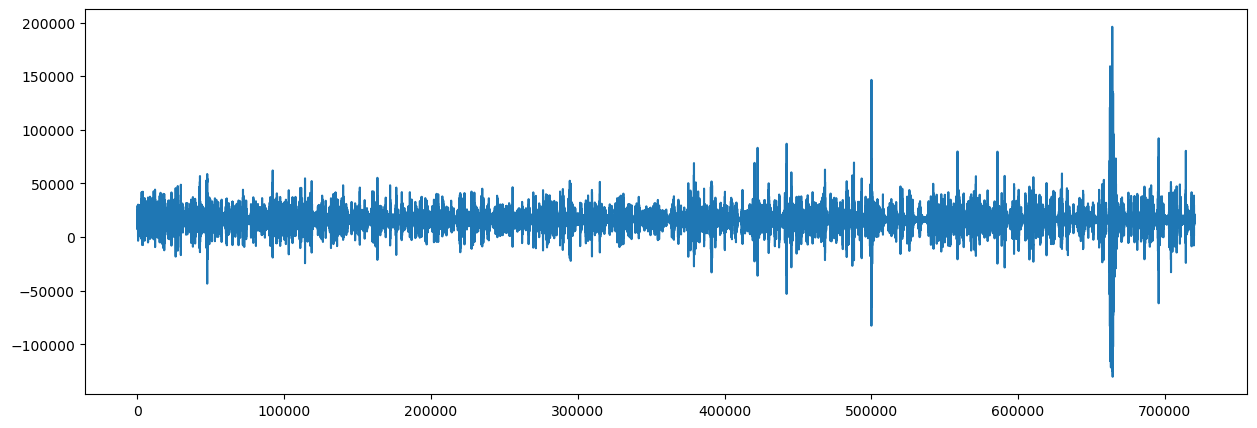

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(time_series, label='Original')
plt.show()

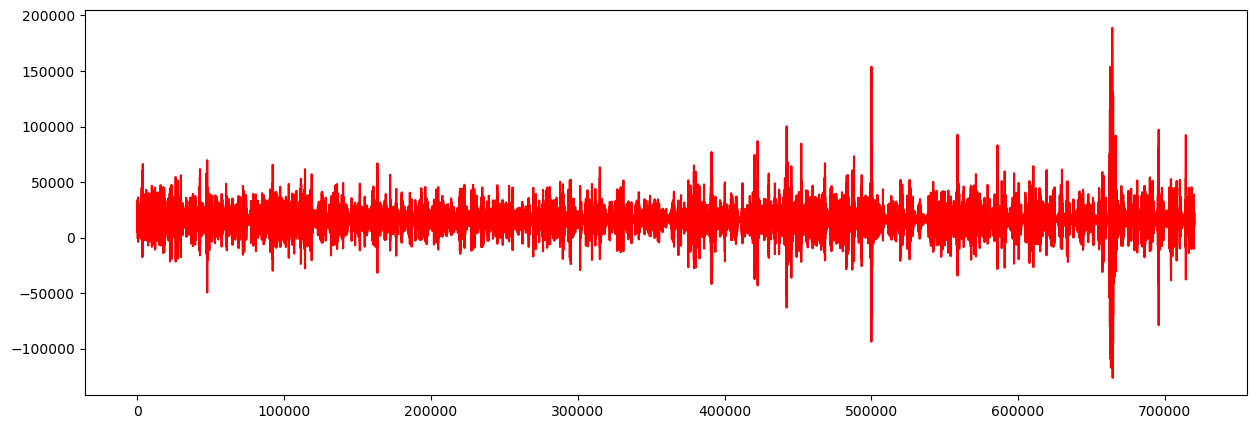

In [38]:
plt.figure(figsize=(15, 5))
plt.plot(predictions, label='Predicted', color='red')
plt.show()


## Trying LSTM #WIP # Need to divide into Train and Test Data

In [42]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# and each sample is a list of amplitude readings

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_amplitudes = scaler.fit_transform(np.array(ShakeDatadf['Samples'].tolist()))

# # Create sequences for LSTM
# def create_sequences(data, time_steps):
#     X, y = [], []
#     for i in range(len(data) - time_steps - 1):
#         a = data[i:(i + time_steps), 0]
#         X.append(a)
#         y.append(data[i + time_steps, 0])
#     return np.array(X), np.array(y)
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(data.shape[0] - time_steps - 1):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :])
    return np.array(X), np.array(y)

time_steps = 50  # For example, use 50 time steps to predict the next step
X, y = create_sequences(scaled_amplitudes, time_steps)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(ShakeDatadf['Samples']).reshape(-1,1))

# Assuming a function 'create_sequences' that turns the data into a sequence
X, y = create_sequences(scaled_data, time_steps=50)

# Reshape the input to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model to the data
# Assuming you have already split your data into train and test sets
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Predict
predicted = model.predict(X_test)

C:\Users\HawkEyERio\AppData\Local\Temp\ipykernel_5580\3096181243.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scaled_amplitudes = scaler.fit_transform(np.array(ShakeDatadf['Samples'].tolist()))


ValueError: setting an array element with a sequence.

In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split


# Pad your data to the same length
padded_data = pad_sequences(ShakeDatadf['Samples'].tolist(), dtype='float64', padding='post')

# Reshape for MinMaxScaler
reshaped_data = padded_data.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_amplitudes = scaler.fit_transform(reshaped_data)

# Reshape back to the original padded data shape
scaled_amplitudes = scaled_amplitudes.reshape(padded_data.shape)

# Function to create sequences for LSTM
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(data.shape[0] - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps][0])  # Assuming you want to predict the next value in the sequence
    return np.array(X), np.array(y)

# Define time_steps and create sequences
time_steps = 50
X, y = create_sequences(scaled_amplitudes, time_steps)

# Reshape X for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model to the data
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Predict
predicted = model.predict(X_test)

# Plotting the results (if necessary)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test, label='True Value')
plt.plot(predicted, label='Predicted Value')
plt.title('Comparison of True and Predicted Values')
plt.legend()
plt.show()

ValueError: cannot reshape array of size 18000050 into shape (1,50,1)

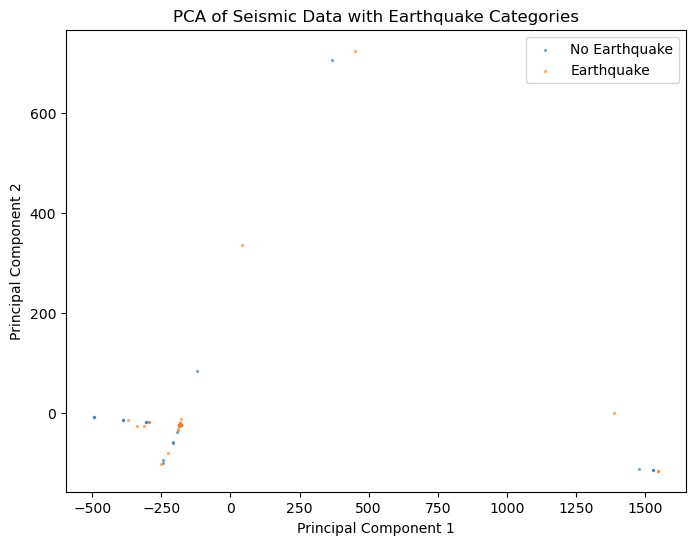

In [29]:
# where 0 indicates 'no earthquake' and 1 indicates 'earthquake'

# This is a computationally expensive step and may require optimization
X = pd.DataFrame(ShakeDatadf['Samples'].tolist())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.fillna(0))  # Fill NA values if any

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a binary category based on a condition in your data
# Here we create a dummy binary variable for the sake of the example
quake_category = np.random.randint(2, size=principal_components.shape[0])

# Plot the first two principal components with different colors
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[quake_category == 0, 0], principal_components[quake_category == 0, 1], alpha=0.5, label='No Earthquake', s=2)
plt.scatter(principal_components[quake_category == 1, 0], principal_components[quake_category == 1, 1], alpha=0.5, label='Earthquake', s=2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Seismic Data with Earthquake Categories')
plt.show()

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

df = pd.read_csv('assets/mushrooms.csv')
df2 = pd.get_dummies(df)

df3 = df2.sample(frac=0.08)

X = df3.iloc[:,2:]
y = df3.iloc[:,1]


pca = PCA(n_components=2).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(pca, y, random_state=0)


plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='Edible', s=2)
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='Poisonous', s=2)
plt.legend()
plt.title('Mushroom Data Set\nFirst Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')

In [12]:
df3.columns

Index(['class_e', 'class_p', 'cap-shape_b', 'cap-shape_c', 'cap-shape_f',
       'cap-shape_k', 'cap-shape_s', 'cap-shape_x', 'cap-surface_f',
       'cap-surface_g',
       ...
       'population_s', 'population_v', 'population_y', 'habitat_d',
       'habitat_g', 'habitat_l', 'habitat_m', 'habitat_p', 'habitat_u',
       'habitat_w'],
      dtype='object', length=119)

In [13]:
X

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
3745,0,0,1,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
6454,0,0,1,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
993,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3554,0,0,0,0,0,1,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4091,0,0,1,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
7852,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
5650,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
5185,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [14]:
y

3745    0
6454    1
993     0
3554    1
4091    1
       ..
1527    0
7852    1
5650    1
5185    0
4357    0
Name: class_p, Length: 650, dtype: uint8

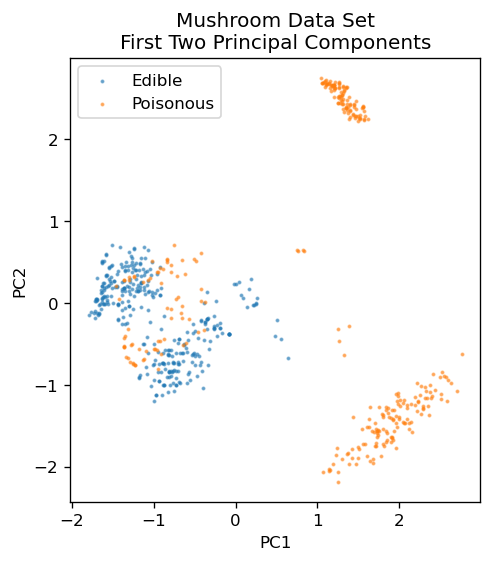

In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

df = pd.read_csv('assets/mushrooms.csv')
df2 = pd.get_dummies(df)

df3 = df2.sample(frac=0.08)

X = df3.iloc[:,2:]
y = df3.iloc[:,1]


pca = PCA(n_components=2).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(pca, y, random_state=0)


plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='Edible', s=2)
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='Poisonous', s=2)
plt.legend()
plt.title('Mushroom Data Set\nFirst Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')